# Анализ данных

In [ ]:
import numpy as np
import scipy.io
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.preprocessing import normalize
import gc

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# !mkdir DEAP
# !unzip -q /content/drive/MyDrive/EEG_Dataset/DEAP/data_preprocessed_matlab.zip -d DEAP

In [ ]:
channels_order_seed = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8',
                    'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ',
                    'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7',
                    'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6',
                    'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']

channels_order_deap = np.array([
    'FP1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5',
    'CP1', 'P3', 'P7', 'PO3', 'O1', 'OZ', 'PZ', 'FP2', 'AF4',
    'FZ', 'F4', 'F8', 'FC6', 'FC2', 'CZ', 'C4', 'T8', 'CP6',
    'CP2', 'P4', 'P8', 'PO4', 'O2'
])

labels_seed = [1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]

## Анализ DE

В рамках анализа было проведено разделение исходных образцов по эмоциональным состояниям и каналом и усреднение по остальным измерениям. После вычитания полученных карт попарно были выявлены каналы Т7 & Т8, показывающие наибольшую межэмоциональную разницу.

In [ ]:
def extract_de(epochs, channels = 62,
               num_band = 5, bands = [1, 4, 8, 13, 31, 50], fq = 200,
               overlap = 0, NFFT = 256, num_time=0):
    file_de = np.zeros([channels, num_time, num_band])
    de = []
    for i in range(channels):
        session_spec, f_, _, _ = plt.specgram(epochs[i, :],
                                            Fs=fq,
                                            noverlap = overlap,
                                            NFFT = NFFT)
        bins = np.digitize(f_, bands)

        for j in range(num_band):
            file_de[i, :, j] = ((session_spec[bins == j+1] - session_spec[bins == j+1].mean(axis=0))**2).mean(axis=0)

    file_de_tmp = 0.5 * np.log(2 * np.pi * np.e * file_de)
    de = np.array(file_de_tmp)
    return de

def brain_3d(data, channels_order, labels, fq = 200, overlap = 0, NFFT = 256):
    data_dict = np.zeros((3, 5, 62))
    for i in range(15):
        eeg_name = [k for k in data.keys() if k[-2:] == "13"][0][:-2] + str(i+1)
        df = data[eeg_name][:,-36000:]
        em = labels[i]

        part_data = extract_de(df, channels = 62,
               num_band = 5, bands = [1, 4, 8, 13, 31, 50], fq = 128,
               overlap = 128, NFFT = 256, num_time=280).mean(axis = 1)
        for f in range(5):
            p = part_data[:,f]
            for j in range(62):
                data_dict[em+1,f,j] += p[j]

    plt.close()
    return data_dict

def brain_3d_all(general_path):
    all_files = [f for f in os.listdir(general_path) if (f[-3:] == "mat") and ("_" in f)]
    all_files = sorted(all_files,
                        key=lambda x: (int(x.split("_")[0]),
                                        int(x.split(".")[0].split("_")[1])
                                        ))

    channels_order = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8',
                    'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ',
                    'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7',
                    'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6',
                    'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']

    labels = [1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]

    data_dict = np.zeros((3, 5, 62))
    for f in tqdm(all_files):
        data = scipy.io.loadmat(os.path.join(general_path, f))
        data_dict += brain_3d(data, channels_order, labels);

    return data_dict

eeg_map = np.array([
    np.array([0, 0, 0, "FP1", "FPZ", "FP2", 0, 0, 0]),
    np.array([0, 0, 0, "AF3", 0, "AF4", 0, 0, 0]),
    np.array(["F7", "F5", "F3", "F1", "FZ", "F2", "F4", "F6", "F8"]),
    np.array(["FT7", "FC5", "FC3", "FC1", "FCZ", "FC2", "FC4", "FC6", "FT8"]),
    np.array(["T7", "C5", "C3", "C1", "CZ", "C2", "C4", "C6", "T8"]),
    np.array(["TP7", "CP5", "CP3", "CP1", "CPZ", "CP2", "CP4", "CP6", "TP8"]),
    np.array(["P7", "P5", "P3", "P1", "PZ", "P2", "P4", "P6", "P8"]),
    np.array([0, "PO7", "PO5", "PO3", "POZ", "PO4", "PO6", "PO8", 0]),
    np.array([0, 0, "CB1", "O1", "OZ", "O2", "CB2", 0, 0])
])

In [ ]:
def hand_filler(data, pos_y, pos_x):
    left = data[pos_y][pos_x-1] if pos_x-1 >= 0 else 0
    right = data[pos_y][pos_x+1] if pos_x+1 < 9 else 0
    top = data[pos_y-1][pos_x] if pos_y-1 >= 0 else 0
    bottom = data[pos_y+1][pos_x] if pos_y+1 < 9 else 0

    neig = np.array([left, right, top, bottom])
    num = (neig != 0).sum()
    return neig.sum()/num

def fill_data(data):
    data_copy = data.copy()
    data_copy[1][4] = hand_filler(data_copy, 1, 4)

    data_copy[1][2] = hand_filler(data_copy, 1, 2)
    data_copy[1][1] = hand_filler(data_copy, 1, 1)
    data_copy[0][2] = hand_filler(data_copy, 0, 2)
    data_copy[0][1] = hand_filler(data_copy, 0, 1)
    data_copy[1][0] = hand_filler(data_copy, 1, 0)
    data_copy[0][0] = hand_filler(data_copy, 0, 0)


    data_copy[1][6] = hand_filler(data_copy, 1, 6)
    data_copy[1][7] = hand_filler(data_copy, 1, 7)
    data_copy[0][6] = hand_filler(data_copy, 0, 6)
    data_copy[0][7] = hand_filler(data_copy, 0, 7)
    data_copy[1][8] = hand_filler(data_copy, 1, 8)
    data_copy[0][8] = hand_filler(data_copy, 0, 8)

    data_copy[7][0] = hand_filler(data_copy, 7, 0)
    data_copy[8][1] = hand_filler(data_copy, 8, 1)
    data_copy[8][0] = hand_filler(data_copy, 8, 0)

    data_copy[7][8] = hand_filler(data_copy, 7, 8)
    data_copy[8][7] = hand_filler(data_copy, 8, 7)
    data_copy[8][8] = hand_filler(data_copy, 8, 8)

    return data_copy

def normal(data):
    return ((data - data.min()) / (data.max() - data.min()))

### SEED

In [ ]:
dat = brain_3d_all("/content/drive/MyDrive/EEG_Dataset/SEED/")
# dat = np.load("3d_map_de.npy")

#### Merged

/tmp/ipython-input-41-1605399945.py:1: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter
/tmp/ipython-input-41-1605399945.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


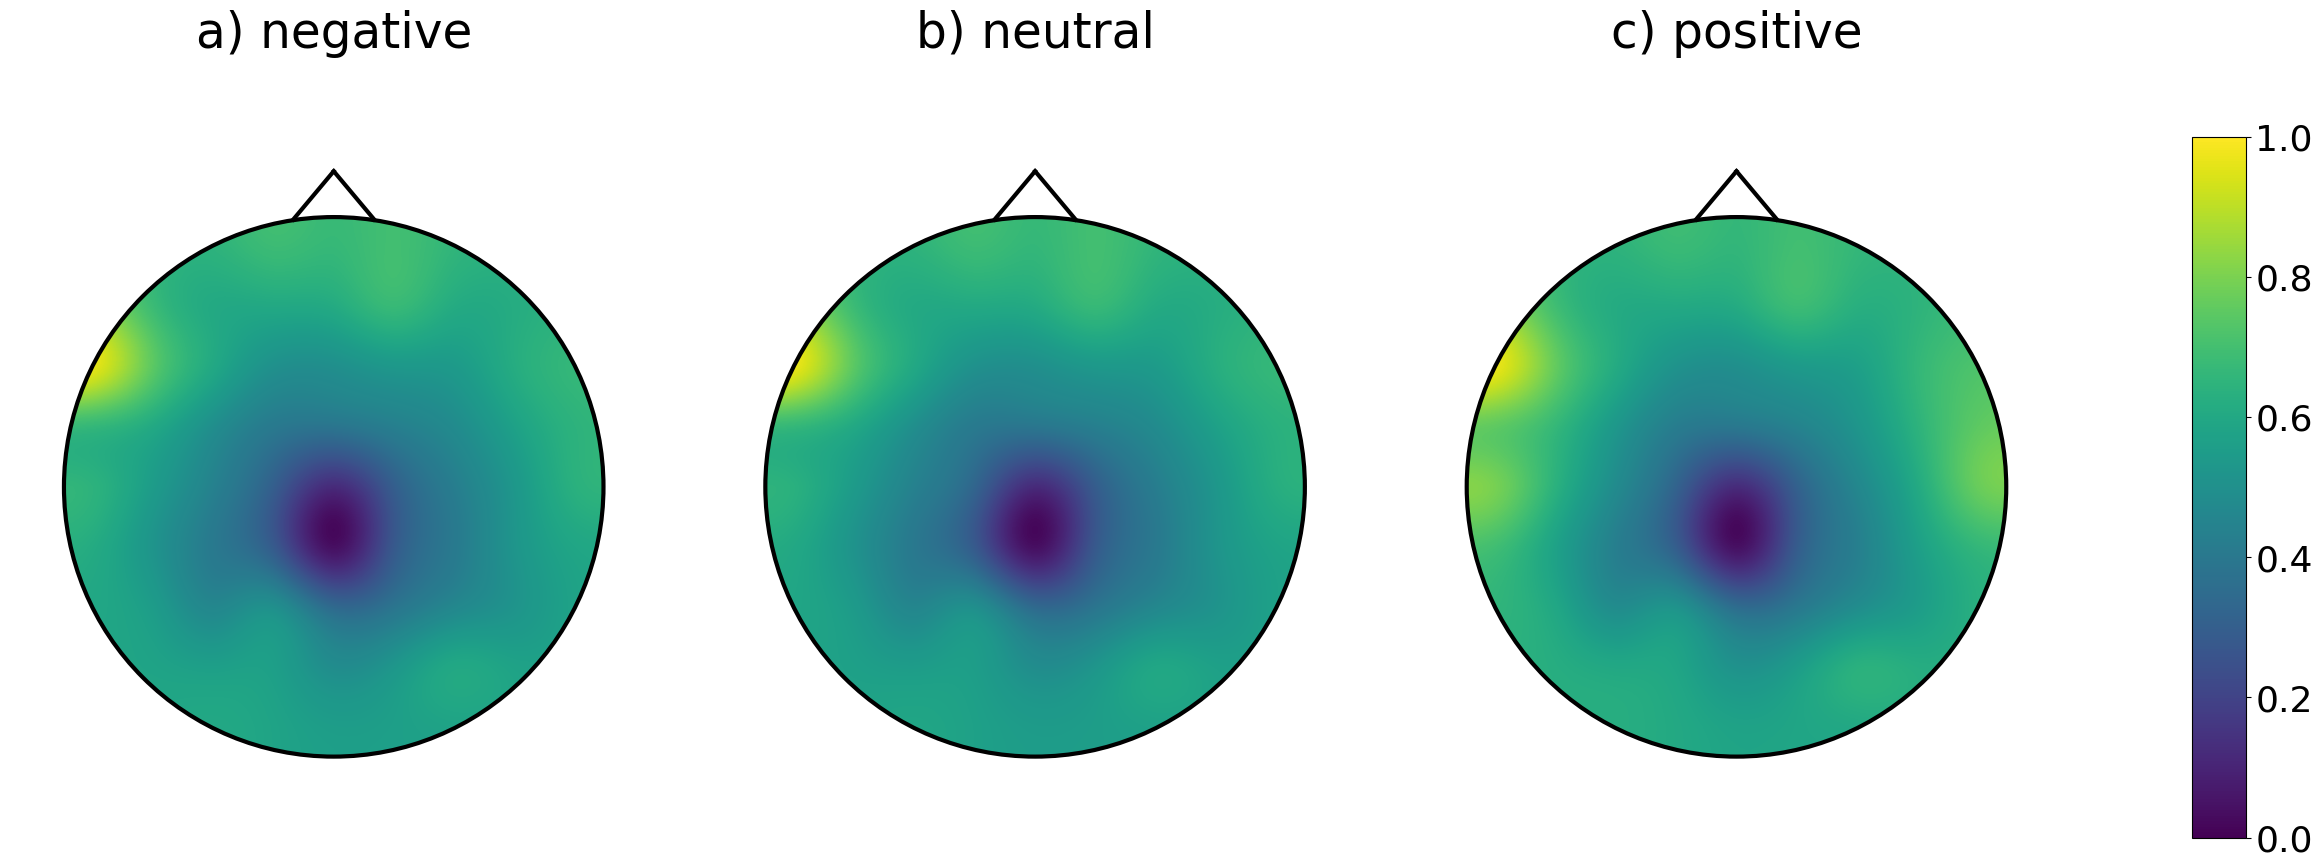

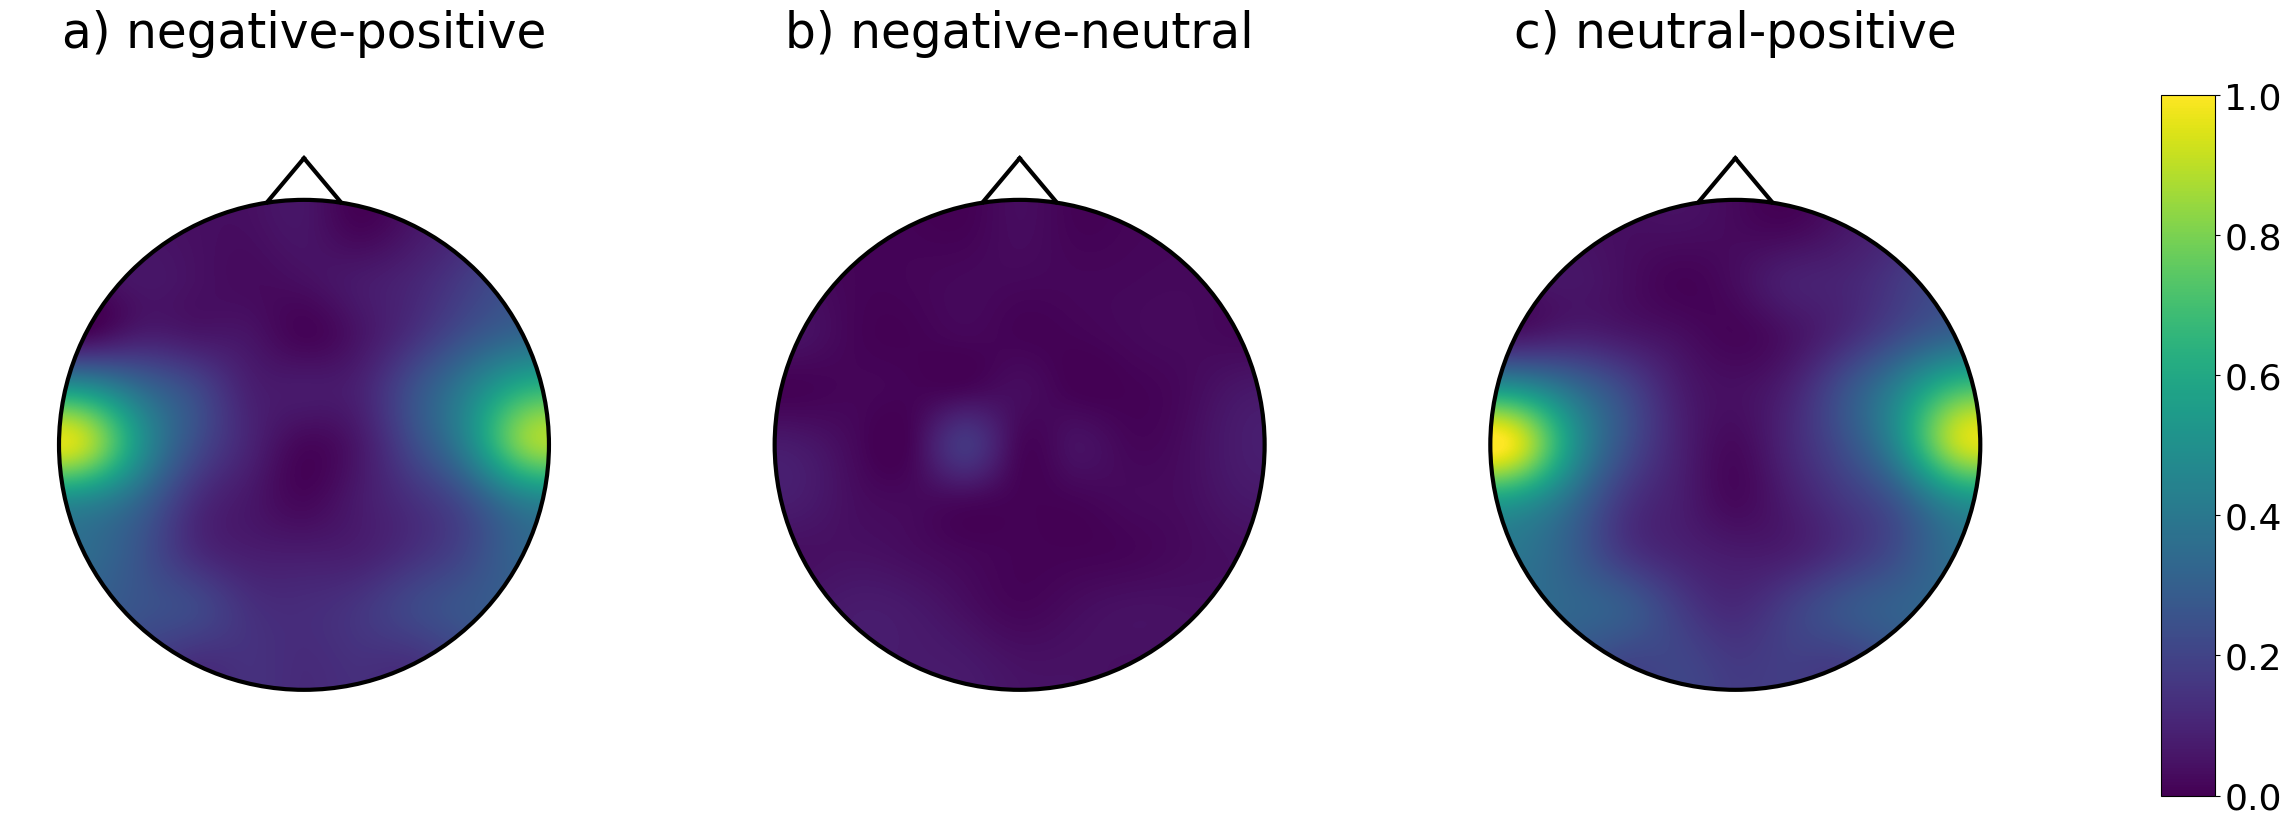

In [ ]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.patches as patches
from matplotlib.lines import Line2D

dat_copy = dat.copy()
freqs_name = ["delta", "theta", "alpha", "beta", "gamma"]
em_name = [
    ["a) negative", "b) neutral", "c) positive"],
    ["a) negative-positive", "b) negative-neutral", "c) neutral-positive"]
]
dat_x = dat.sum(axis=1)
dat_copy = normal(dat_x)

neg_pos = abs(dat_copy[0] - dat_copy[2])
neg_neut = abs(dat_copy[0] - dat_copy[1])
neut_pos = abs(dat_copy[1] - dat_copy[2])
dat_copy = [dat_copy, normal(np.array([neg_pos, neg_neut, neut_pos]))]

for b in range(2):
    fig, axs = plt.subplots(1, 3, figsize=(21,7))
    for a in range(3):
        em = {channels_order_seed[i]: dat_copy[b][a][i] for i in range(62)}
        matrix = eeg_map.copy()
        m = []
        for i in range(matrix.shape[0]):
            tmp = []
            for j in range(matrix.shape[1]):
                if matrix[i][j] in em.keys():
                    tmp.append(em[matrix[i][j]])
                else:
                    tmp.append(0)
            m.append(np.array(tmp))
        m = np.array(m)
        m = fill_data(m)

        m=gaussian_filter(m, 0.4)

        circ = patches.Circle((10, 10), radius=10, facecolor='none', linewidth=3, edgecolor='black')
        line_1 = Line2D([8.5,10], [19.91,21.7], linewidth=3, linestyle = "-", color="black")
        line_2 = Line2D([10,11.5], [21.7,19.91], linewidth=3, linestyle = "-", color="black")

        ax = axs[a]
        ax.text(0.5, 1.2, em_name[b][a], va='center', ha='center', fontsize=35,
                transform=ax.transAxes)
        ax.add_patch(circ)
        ax.add_line(line_1)
        ax.add_line(line_2)

        ax.set_axis_off()
        pcm = ax.imshow(m, cmap='viridis', interpolation='spline36', vmin=0,
                    vmax=1.0, extent=[0, 20, 0, 20], clip_path=circ, clip_on=True)
        ax.set_ylim((-2, 22))
        ax.set_xlim((-2, 22))

    cbar = fig.colorbar(pcm, ax=axs[:], shrink=1.3, anchor=(3.0,0.55), aspect=13)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(26)
    plt.tight_layout()
    plt.show()

#### Separate frequency bands

/tmp/ipython-input-44-4290178716.py:1: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter
/tmp/ipython-input-44-4290178716.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


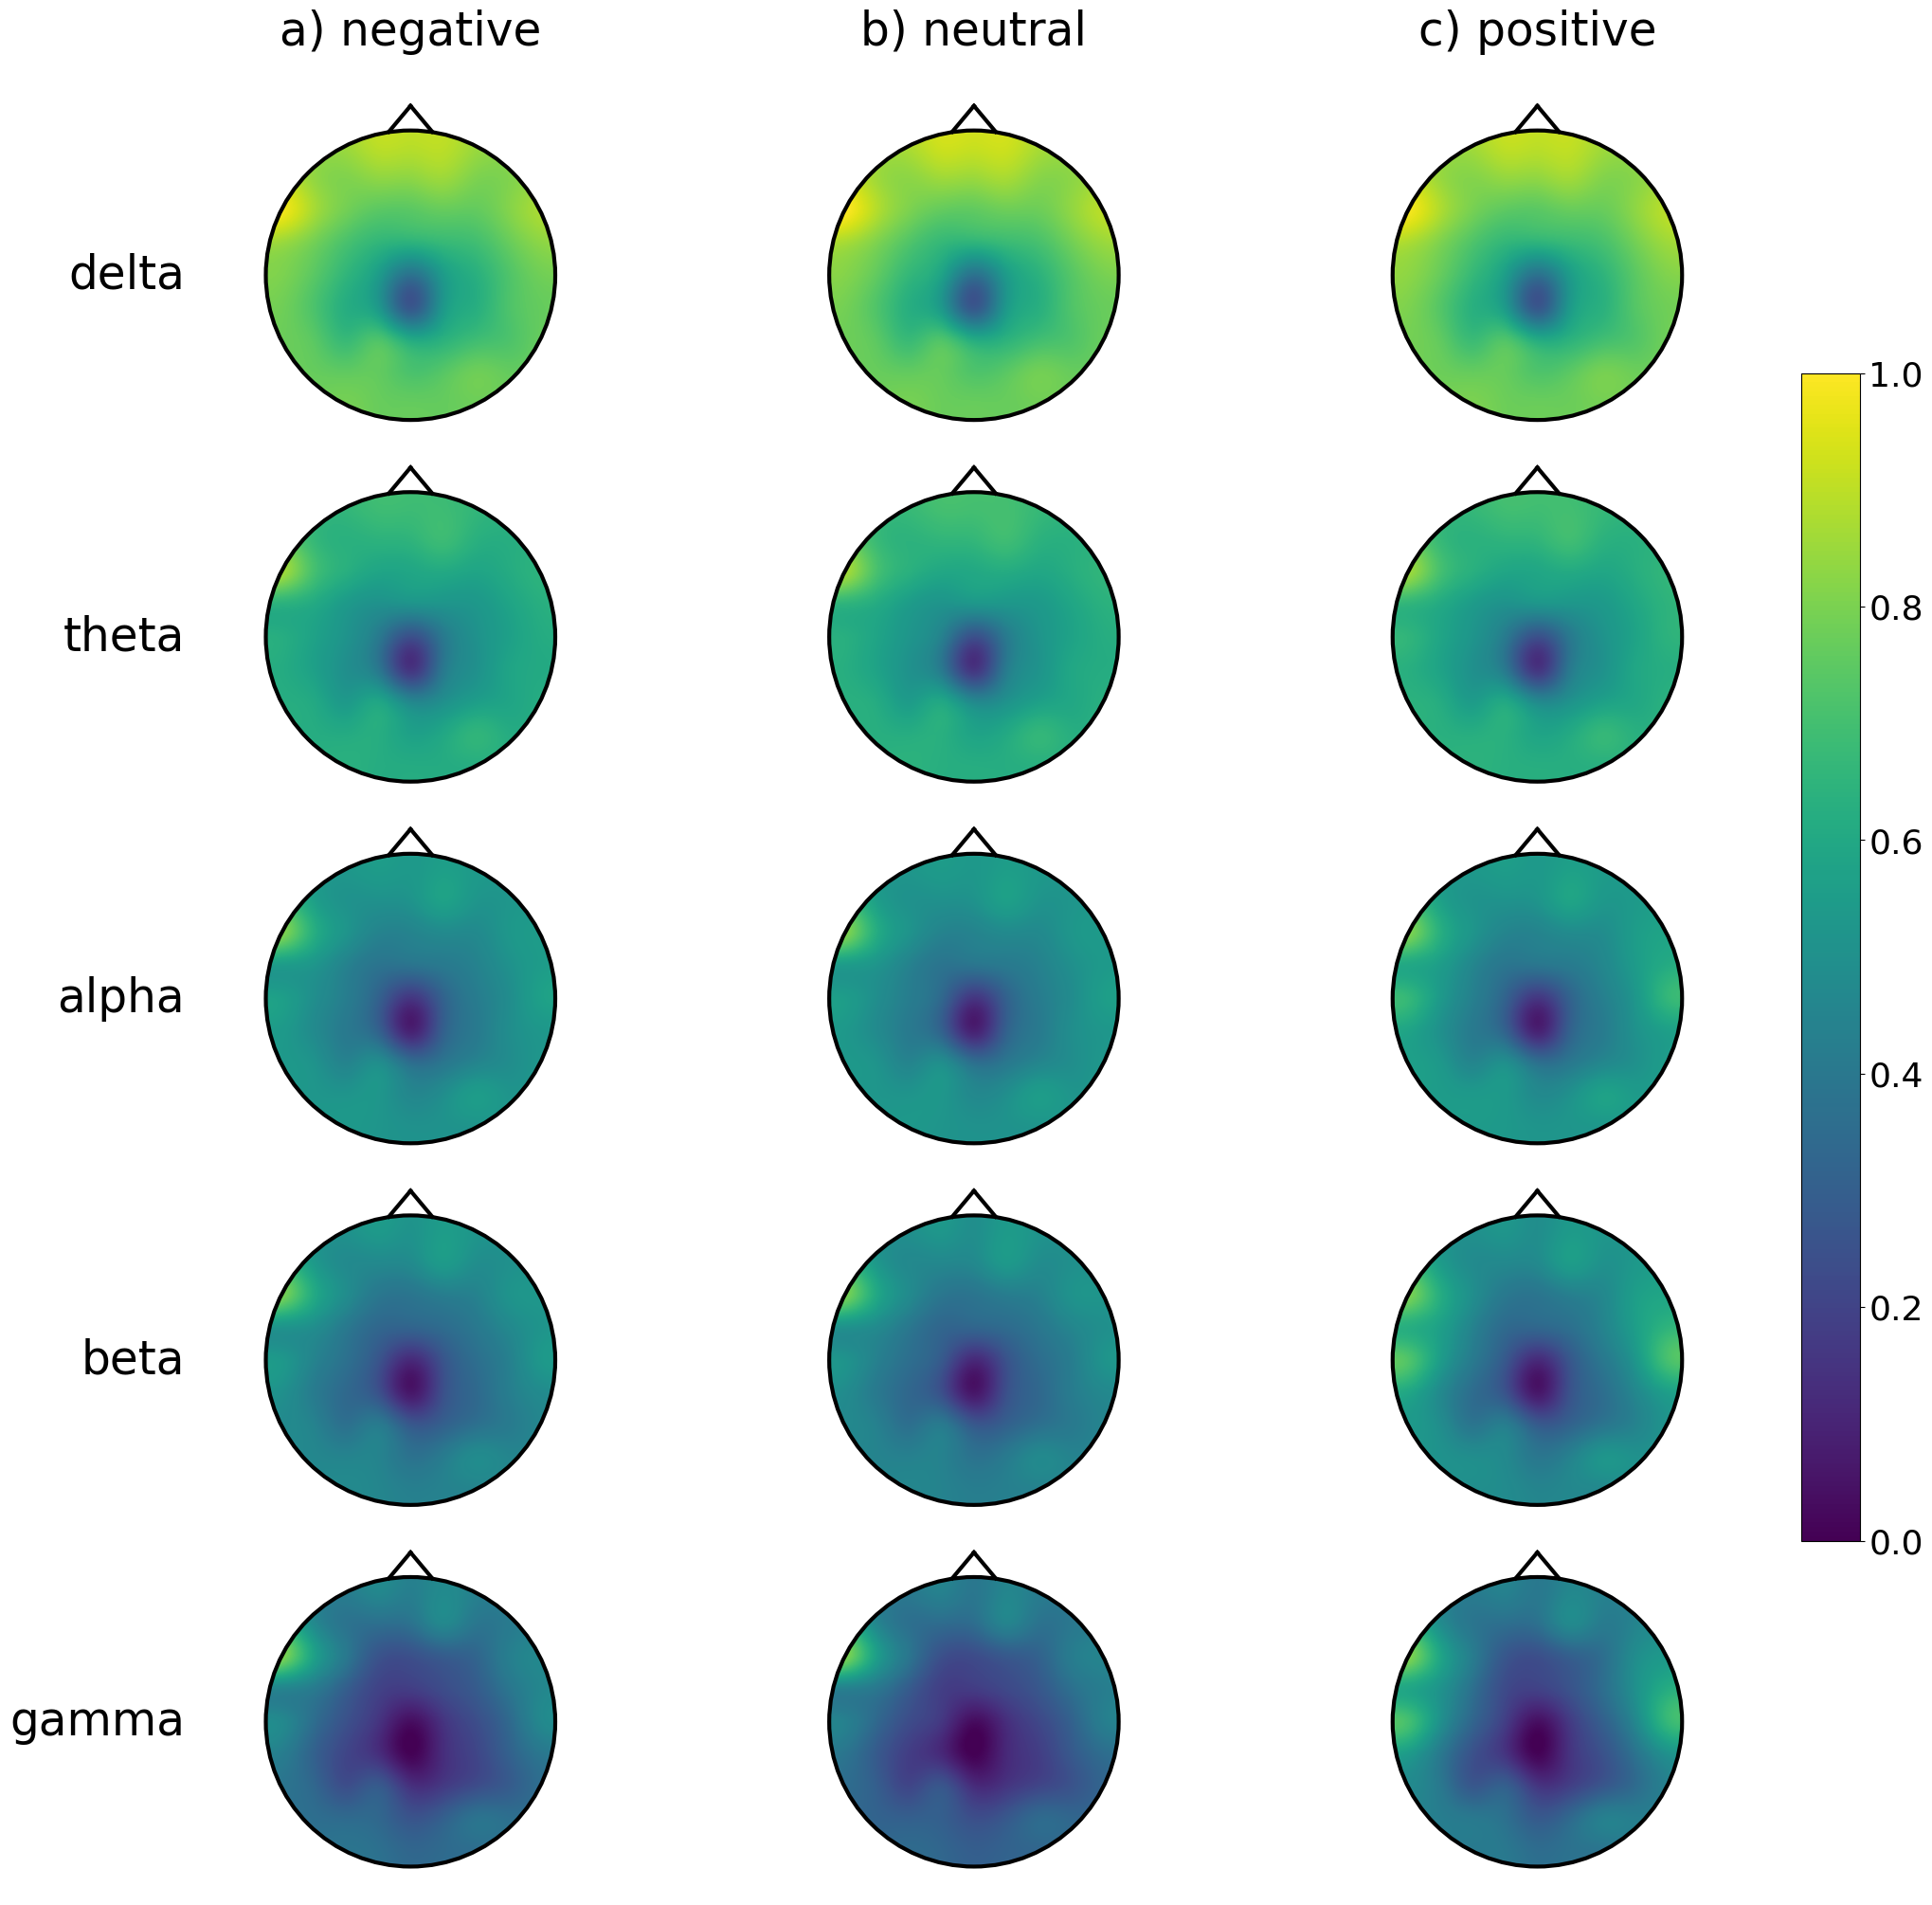

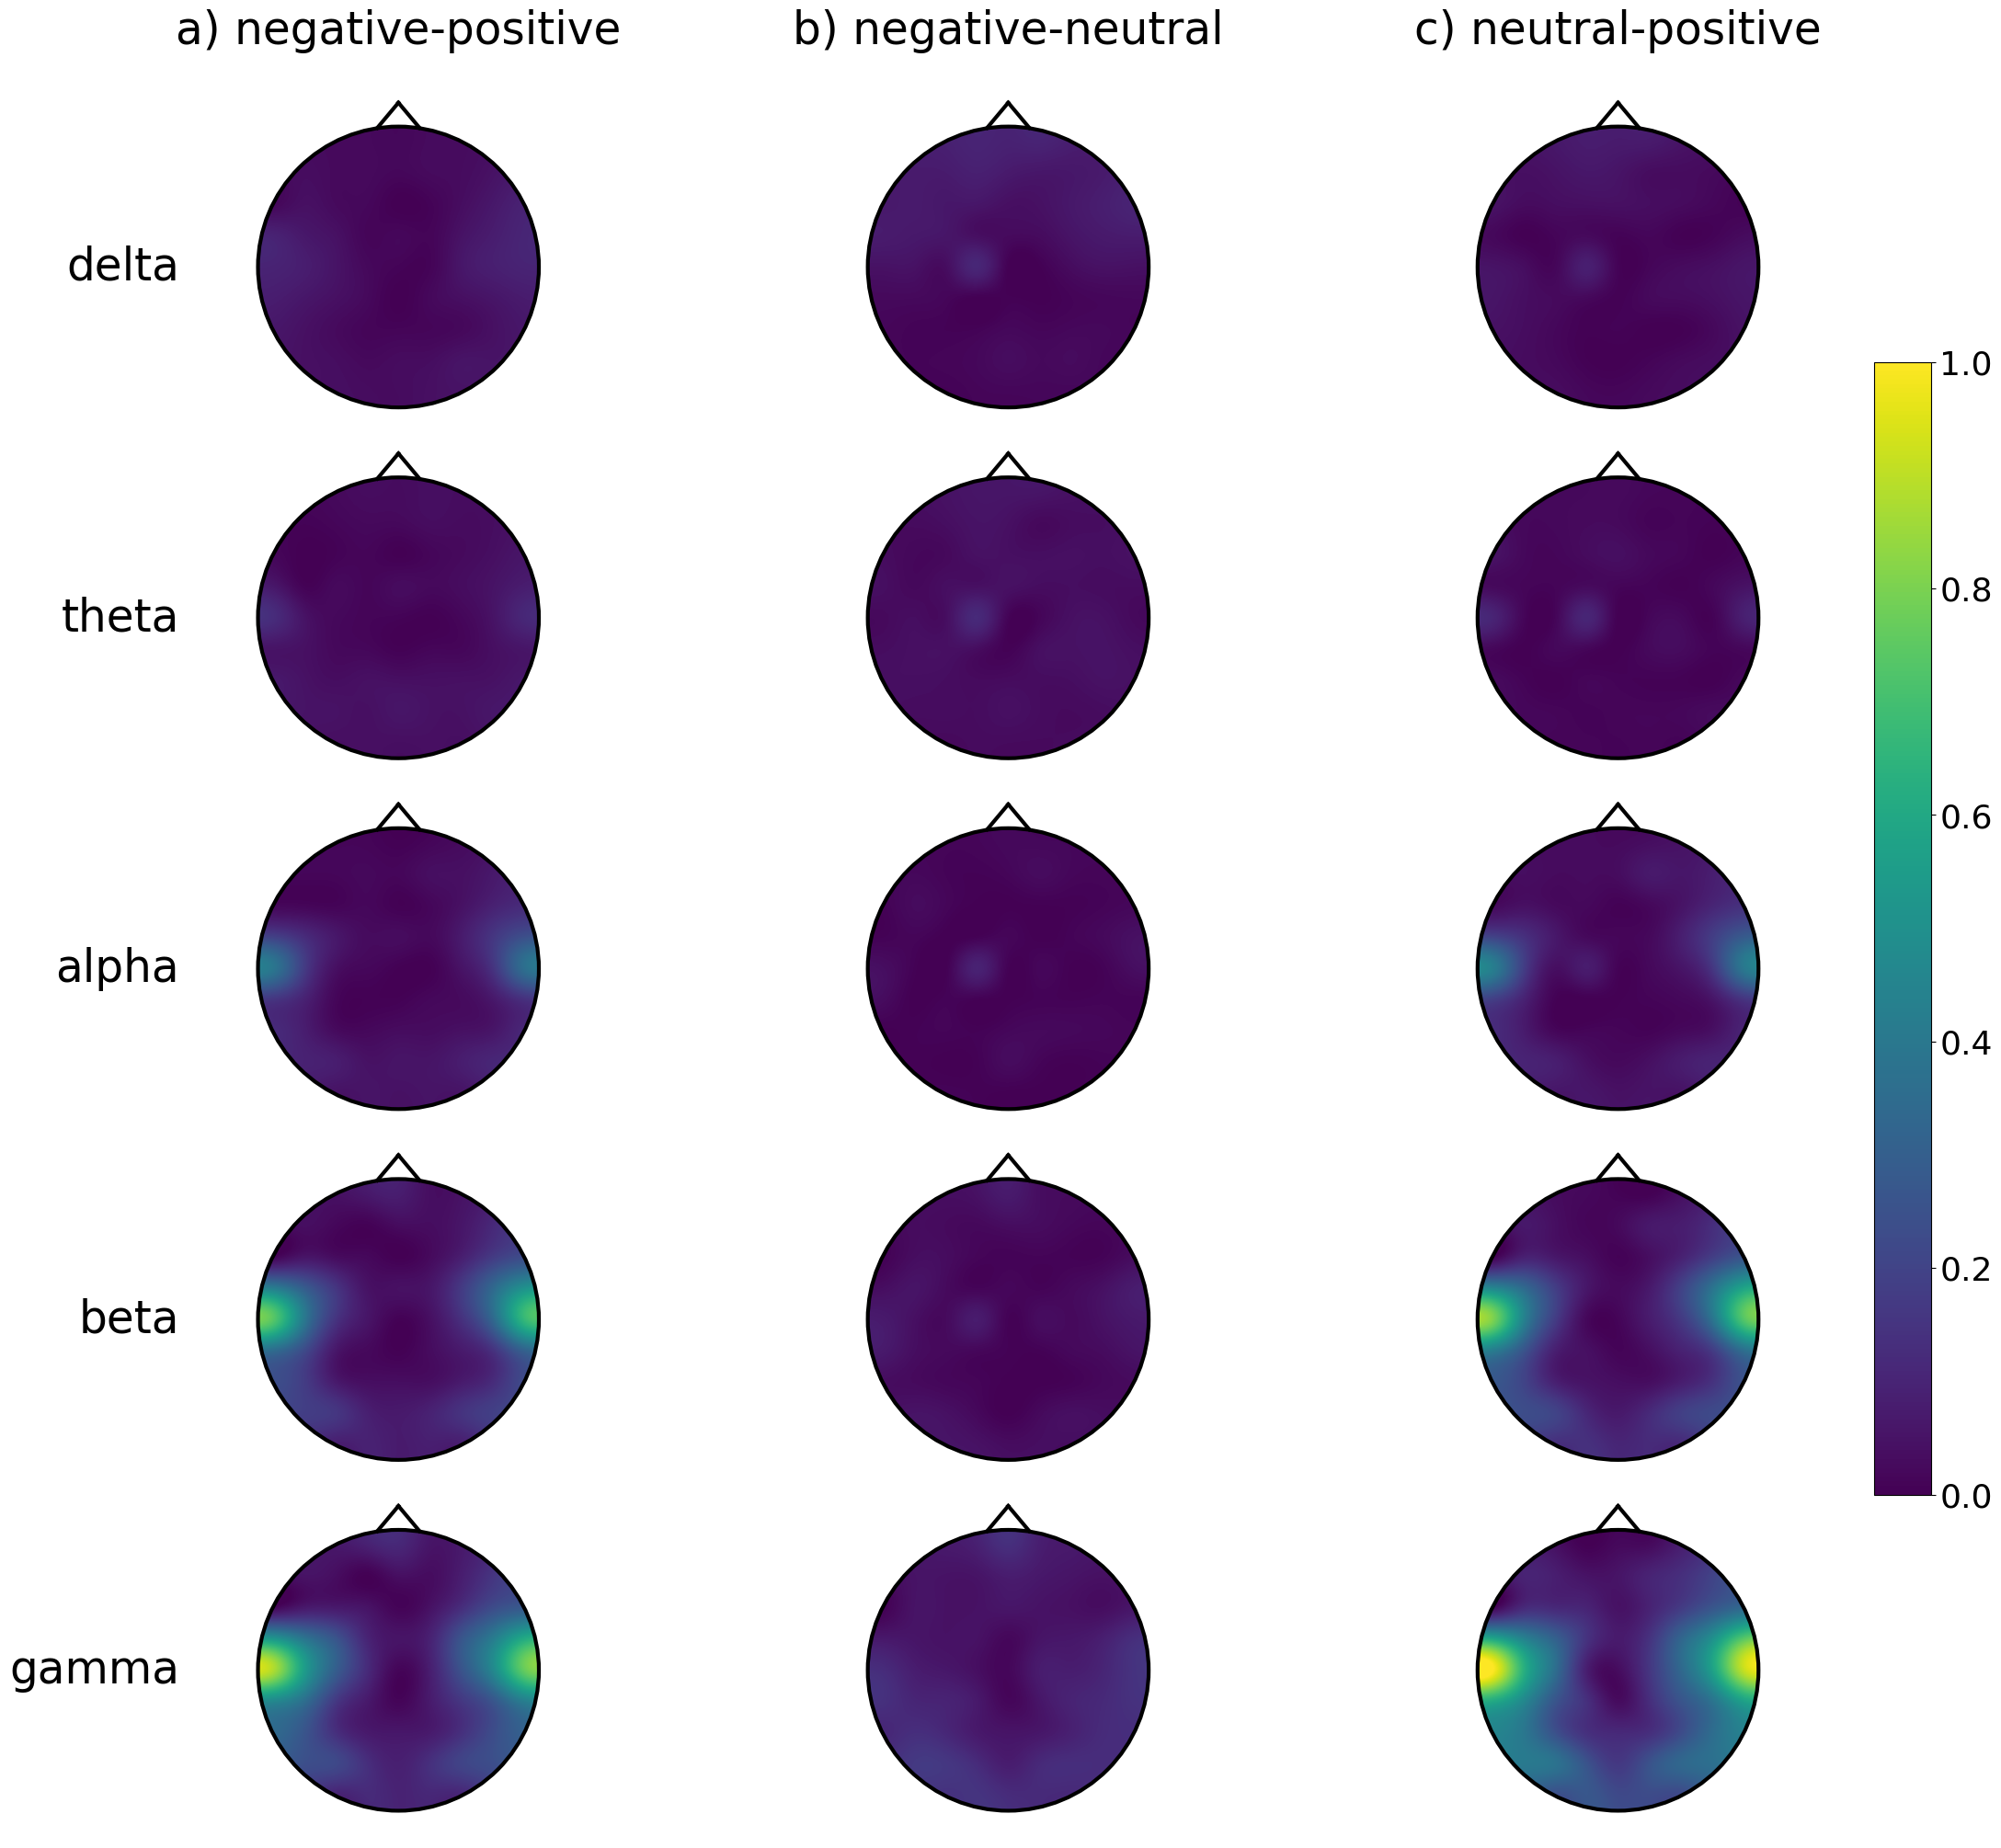

In [ ]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.patches as patches
from matplotlib.lines import Line2D

freqs_name = ["delta", "theta", "alpha", "beta", "gamma"]
em_name = [
    ["a) negative", "b) neutral", "c) positive"],
    ["a) negative-positive", "b) negative-neutral", "c) neutral-positive"]
]
dat_copy = normal(dat)
dat1 = np.array([abs(dat_copy[0] - dat_copy[2]), abs(dat_copy[0] - dat_copy[1]), abs(dat_copy[1] - dat_copy[2])])
dat1 = [dat_copy, normal(dat1)]

for c in range(2):
    fig, axs = plt.subplots(5, 3, figsize=(20,20))
    for a in range(3):
        for b in range(5):
            em = {channels_order_seed[i]: dat1[c][a][b][i] for i in range(62)}
            matrix = eeg_map.copy()
            m = []
            for i in range(matrix.shape[0]):
                tmp = []
                for j in range(matrix.shape[1]):
                    if matrix[i][j] in em.keys():
                        tmp.append(em[matrix[i][j]])
                    else:
                        tmp.append(0)
                m.append(np.array(tmp))
            m = np.array(m)
            m = fill_data(m)

            circ = patches.Circle((10, 10), radius=10, facecolor='none', linewidth=3, edgecolor='black')
            line_1 = Line2D([8.5,10], [19.91,21.7], linewidth=3, linestyle = "-", color="black")
            line_2 = Line2D([10,11.5], [21.7,19.91], linewidth=3, linestyle = "-", color="black")

            ax = axs[b, a]
            if a == 0:
                ax.text(-.15, .5, freqs_name[b], va='center', ha='right', fontsize=35,
                        transform=ax.transAxes)
            if b == 0:
                ax.text(0.5, 1.2, em_name[c][a], va='center', ha='center', fontsize=35,
                        transform=ax.transAxes)

            ax.add_patch(circ)
            ax.add_line(line_1)
            ax.add_line(line_2)

            ax.set_axis_off()
            pcm = ax.imshow(m, cmap='viridis', interpolation='spline36', vmin=0,
                        vmax=1, extent=[0, 20, 0, 20], clip_path=circ, clip_on=True)
            ax.set_ylim((-2, 22))
            ax.set_xlim((-2, 22))

    cbar = fig.colorbar(pcm, ax=axs[:, :], shrink=0.8, anchor=(3.0,0.55))
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(26)
    plt.tight_layout()
    plt.show()

### DEAP

In [ ]:
def line_idx(data, channels, fq = 200, overlap = 128, NFFT = 256):
    labels = data["labels"][:,0]
    labels = np.array(data["labels"][:,0] >= 5)
    dict_val = {}
    dict_val = []
    d = data["data"][:, :32, -60*128:]
    mm = data["data"][:, :32, :3*128]
    mm = np.mean([mm[:, :, :128], mm[:, :, 128:256], mm[:, :, 256:]], axis=0)
    mm = mm.reshape(mm.shape[0],mm.shape[1], 1, mm.shape[2]).repeat(60, axis=-2).reshape(d.shape)
    d = d - mm
    d = (d - np.mean(d, axis=-1)[:, :, None].repeat(60*128, axis=-1)) / np.std(d, axis=-1)[:, :, None].repeat(60*128, axis=-1)
    for k in range(32):
        idx = k
        df = np.reshape(d[:, idx, :], (40, -1, 128))

        pos = df[labels,:,:]
        neg = df[~labels,:,:]

        pos_mean = pos.mean()
        neg_mean = neg.mean()

        dict_val.append(np.array([pos_mean, neg_mean]))

    return np.array(dict_val).T

def line_run_all(channels_order, path = "/content/DEAP/"):
    files = sorted(os.listdir(path))
    whole_data = np.zeros((2,32))
    for f in tqdm(files):
        data_path = path + f
        data = scipy.io.loadmat(data_path)
        whole_data += line_idx(data, channels_order)
    return whole_data

def hand_filler(data, pos_y, pos_x):
    left = data[pos_y][pos_x-1] if pos_x-1 >= 0 else 0
    right = data[pos_y][pos_x+1] if pos_x+1 < 9 else 0
    top = data[pos_y-1][pos_x] if pos_y-1 >= 0 else 0
    bottom = data[pos_y+1][pos_x] if pos_y+1 < 9 else 0

    neig = np.array([left, right, top, bottom])
    num = (neig != 0).sum()
    return neig.sum()/num

def fill_data(data):
    data_copy = data.copy()
    pairs = [
        [2,1], [2,3], [2,5], [2,7],
        [3,0], [3,2], [3,4], [3,6], [3,8],
        [4,1], [4,3], [4,5], [4,7],
        [5,0], [5,2], [5,4], [5,6], [5,8],
        [6,1], [6,3], [6,5], [6,7],
        [1,4], [1,2], [1,1], [1,0], [1,6], [1,7], [1,8],
        [7,4], [7,2], [7,1], [7,0], [7,6], [7,7], [7,8],
        [0,4], [0,2], [0,1], [0,0], [0,6], [0,7], [0,8],
        [8,2], [8,1], [8,0], [8,6], [8,7], [8,8],
    ]
    for pair in pairs:
        a, b = pair
        data_copy[a][b] = hand_filler(data_copy, a, b)

    return data_copy

eeg_map = np.array([
    np.array([0, 0, 0, "FP1", 0, "FP2", 0, 0, 0]),
    np.array([0, 0, 0, "AF3", 0, "AF4", 0, 0, 0]),
    np.array(["F7", 0, "F3", 0, "FZ", 0, "F4", 0, "F8"]),
    np.array([0, "FC5", 0, "FC1", 0, "FC2", 0, "FC6", 0]),
    np.array(["T7", 0, "C3", 0, "CZ", 0, "C4", 0, "T8"]),
    np.array([0, "CP5", 0, "CP1", 0, "CP2", 0, "CP6", 0]),
    np.array(["P7", 0, "P3", 0, "PZ", 0, "P4", 0, "P8"]),
    np.array([0, 0, 0, "PO3", 0, "PO4", 0, 0, 0]),
    np.array([0, 0, 0, "O1", "OZ", "O2", 0, 0, 0])
])

In [ ]:
dict_dat = line_run_all(channels_order_deap)

100%|██████████| 32/32 [01:01<00:00,  1.91s/it]


/tmp/ipython-input-56-143357886.py:1: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter
/tmp/ipython-input-56-143357886.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


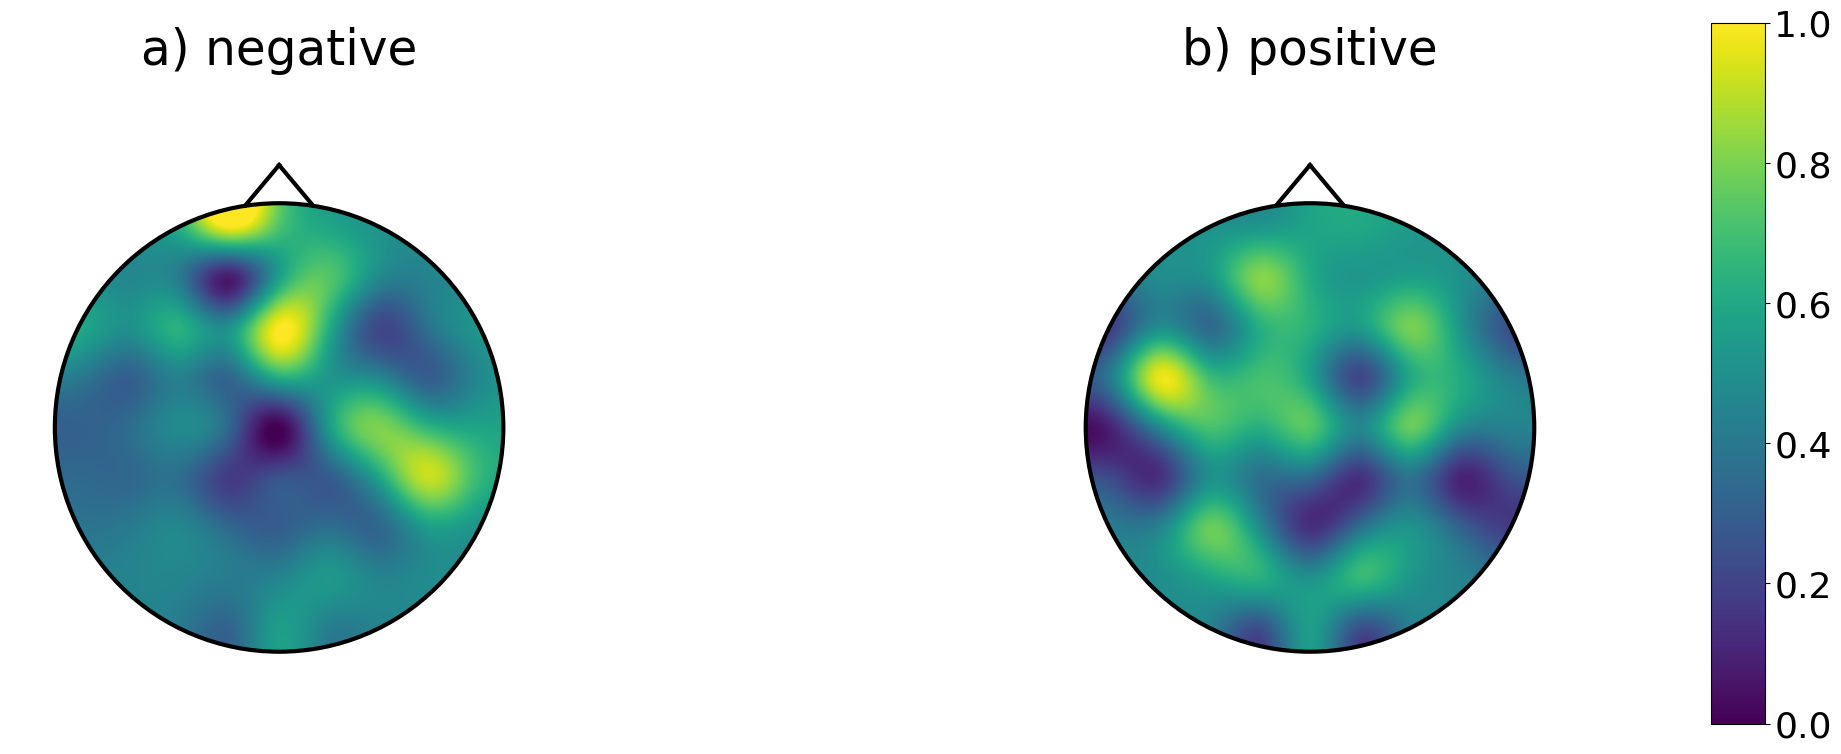

In [ ]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.patches as patches
from matplotlib.lines import Line2D


freqs_name = ["delta", "theta", "alpha", "beta", "gamma"]
em_name = ["a) negative", "b) positive"]
dat = dict_dat.copy()/32
dat_copy = normal(dat)

fig, axs = plt.subplots(1, 2, figsize=(21,7))
for a in range(2):
    em = {channels_order_deap[i]: dat_copy[a][i] for i in range(32)}
    matrix = eeg_map.copy()
    m = []
    for i in range(matrix.shape[0]):
        tmp = []
        for j in range(matrix.shape[1]):
            if matrix[i][j] in em.keys():
                tmp.append(em[matrix[i][j]])
            else:
                tmp.append(np.array(list(em.values())).mean())
        m.append(np.array(tmp))
    m = np.array(m)
    m = fill_data(m)

    circ = patches.Circle((10, 10), radius=10, facecolor='none', linewidth=3, edgecolor='black')
    line_1 = Line2D([8.5,10], [19.91,21.7], linewidth=3, linestyle = "-", color="black")
    line_2 = Line2D([10,11.5], [21.7,19.91], linewidth=3, linestyle = "-", color="black")

    ax = axs[a]
    ax.text(0.5, 1.2, em_name[a], va='center', ha='center', fontsize=35,
            transform=ax.transAxes)

    ax.add_patch(circ)
    ax.add_line(line_1)
    ax.add_line(line_2)

    ax.set_axis_off()
    pcm = ax.imshow(m, cmap='viridis', interpolation='spline36', vmin=0,
                vmax=1.0, extent=[0, 20, 0, 20], clip_path=circ, clip_on=True)

    ax.set_ylim((-2, 22))
    ax.set_xlim((-2, 22))

cbar = fig.colorbar(pcm, ax=axs[:], shrink=1.3, anchor=(3.0,0.55), aspect=13)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(26)
plt.tight_layout()
plt.show()

## Проверка каналов T7 & T8 на спектрограммах

По результатам анализа была визуализирована объединенная спектрограмма всех видео одной серии просмотров для двух случайных пользователей на выявленных каналах T7 & T8. Разные эмоциональные состояния были отмечены уровными отличными по высоте.

Для датасета SEED, в отличие от DEAP, прослеживается четкая разница между позитивной и остальными эмоциями для всех экспериментов.

In [ ]:
from matplotlib.lines import Line2D

def specgram_idx_seed(data, channels, channel_name, r = None, fq = 200, overlap = 128, NFFT = 256):
    if r:
        eeg_name = [k for k in data.keys() if k[-2:] == "13"][0][:-2] + str(r + 1)
        df = data[eeg_name][:,-36000:]
    else:
        eeg_name = [k for k in data.keys() if k[-2:] == "13"][0][:-2] + str(1)
        df = data[eeg_name][:,-36000:]
        for i in range(1, 15):
            eeg_name = [k for k in data.keys() if k[-2:] == "13"][0][:-2] + str(i+1)
            df = np.concatenate((df, data[eeg_name][:,-36000:]), axis=1)
    data_dict = {channels_order_seed[i]: df[i] for i in range(62)}
    session_spec, f_, a, x = plt.specgram(data_dict[channel_name], Fs=fq, noverlap = overlap, NFFT = NFFT);
    filtered = np.log10(session_spec[:, :][(f_ >= 1) & (f_ <= 50)])
    filtered = ((filtered - filtered.min()) / (filtered.max() - filtered.min()))*100

    plt.close()
    return filtered

def specgram_jigsaw_seed(data, channels_order, channel, p = 1, baseline = 6, linewidths = 2):
    a = np.flip(specgram_idx_seed(data, channels_order, channel), axis = 0)[:, :]
    fig, ax = plt.subplots(figsize=(25,15))
    koef = 5
    for k in range(15):
        level = labels_seed[k]*koef + baseline
        left = k*koef
        right = (k+1)*koef
        plt.hlines(level, xmin = left, xmax = right, colors="black", linewidths = linewidths)


    ax.text(0.99, 0.601, "-", va='center', ha='left', fontsize=55,
            transform=ax.transAxes)
    ax.text(0.99, 0.701, "-", va='center', ha='left', fontsize=55,
            transform=ax.transAxes)
    ax.text(0.99, 0.801, "-", va='center', ha='left', fontsize=55,
            transform=ax.transAxes)

    ax.text(1.01, 0.6, "negative", va='center', ha='left', fontsize=35,
            transform=ax.transAxes)
    ax.text(1.01, 0.7, "neutral", va='center', ha='left', fontsize=35,
            transform=ax.transAxes)
    ax.text(1.01, 0.8, "positive", va='center', ha='left', fontsize=35,
            transform=ax.transAxes)

    for k in range(1, 15):
        level_1 = labels_seed[k-1]*koef + baseline
        level_2 = labels_seed[k]*koef + baseline
        plt.vlines(k*koef, ymin = level_1, ymax = level_2, colors="black", linewidths = linewidths)

    plt.imshow(a, cmap='viridis', interpolation='nearest', vmin=50,
               vmax=85, extent=[0, 15*koef, 0, 50])
    plt.title(f"Spectrogram. Person {p}. Channel {channel}", fontsize=45, y=1.02)
    plt.ylim(0,50)
    plt.xlabel("Time", fontsize=40)
    plt.ylabel("Frequency", fontsize=40, x=-0.1)
    cbar = plt.colorbar(anchor=(0.8,0.55))
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    plt.show()

def specgram_idx_deap(data, channels, channel_name, fq = 200, overlap = 128, NFFT = 256):
    labels = data["labels"][:,0]
    labels = np.array(data["labels"][:,0] > 5)*1.0
    # labels = np.array(data_p32["labels"][:,0] > 5.)*1 + np.array(data_p32["labels"][:,1] > 5.)*2
    # labels = (labels > 7)*1 + ((labels <= 7) & (labels >= 4))*0 + (labels < 4)*(-1)
    df = data["data"][:, :32, 3*128:]
    df = np.reshape(np.swapaxes(df,0,1), (32,-1))

    # if normalize:
    #     df = (df - df.min(axis=1).reshape(-1, 1)) / (df.max(axis=1).reshape(-1, 1) - df.min(axis=1).reshape(-1, 1))

    data_dict = {channels[i]: df[i] for i in range(32)}
    session_spec, f_, a, x = plt.specgram(data_dict[channel_name], Fs=fq, noverlap = overlap, NFFT = NFFT);

    filtered = np.log10(session_spec[:, :][(f_ >= 1) & (f_ <= 50)])
    # filtered = session_spec[:, :]
    filtered = ((filtered - filtered.min()) / (filtered.max() - filtered.min()))*100
    plt.close()
    return filtered, labels

def specgram_jigsaw_deap(data, channels_order, channel, p = 1, baseline = 6, linewidths = 2, vids = 40):
    a, labels = specgram_idx_deap(data, channels_order, channel)
    a = np.flip(a, axis = 0)[:, :]
    # a = specgram_idx(data, channels_order, "T7")
    fig, ax = plt.subplots(figsize=(25,15))

    koef = 5
    for k in range(vids):
        level = koef*labels[k] + baseline
        left = koef*k
        right = koef*(k+1)
        # print(level)
        plt.hlines(level, xmin = left, xmax = right, colors="black", linewidths = linewidths)

    ax.text(0.995, 0.701, "-", va='center', ha='left', fontsize=35,
            transform=ax.transAxes)
    ax.text(0.995, 0.801, "-", va='center', ha='left', fontsize=35,
            transform=ax.transAxes)

    ax.text(1.01, 0.7, "negative", va='center', ha='left', fontsize=20,
            transform=ax.transAxes)
    ax.text(1.01, 0.8, "positive", va='center', ha='left', fontsize=20,
            transform=ax.transAxes)

    for k in range(1, vids):
        level_1 = koef*labels[k-1] + baseline
        level_2 = koef*labels[k] + baseline
        plt.vlines(koef*k, ymin = level_1, ymax = level_2, colors="black", linewidths = linewidths)
    plt.imshow(a, cmap='viridis', interpolation='nearest', vmin=65,
               vmax=85, extent=[0, koef*vids, 0, 50])
    plt.title(f"Spectrogram. Person {p}. Channel {channel}", fontsize=35, y=1.02)
    plt.xlabel("Time", fontsize=25)
    plt.ylabel("Frequency", fontsize=25)
    # plt.imshow(a, cmap='viridis', interpolation='nearest', vmin=30,
    #         vmax=65, extent=[0, 15, 0, 10])
    cbar = plt.colorbar(anchor=(0.5,0.5), shrink=0.4, aspect=11)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.show()

### SEED

In [ ]:
data_path_p1_t1 = "/content/drive/MyDrive/EEG_Dataset/SEED/1_20131027.mat"
data_path_p1_t2 = "/content/drive/MyDrive/EEG_Dataset/SEED/1_20131030.mat"

data_path_p2_t1 = "/content/drive/MyDrive/EEG_Dataset/SEED/3_20140603.mat"
data_path_p2_t2 = "/content/drive/MyDrive/EEG_Dataset/SEED/3_20140611.mat"

data_p1_t1 = scipy.io.loadmat(data_path_p1_t1)
data_p1_t2 = scipy.io.loadmat(data_path_p1_t2)

data_p2_t1 = scipy.io.loadmat(data_path_p2_t1)
data_p2_t2 = scipy.io.loadmat(data_path_p2_t2)

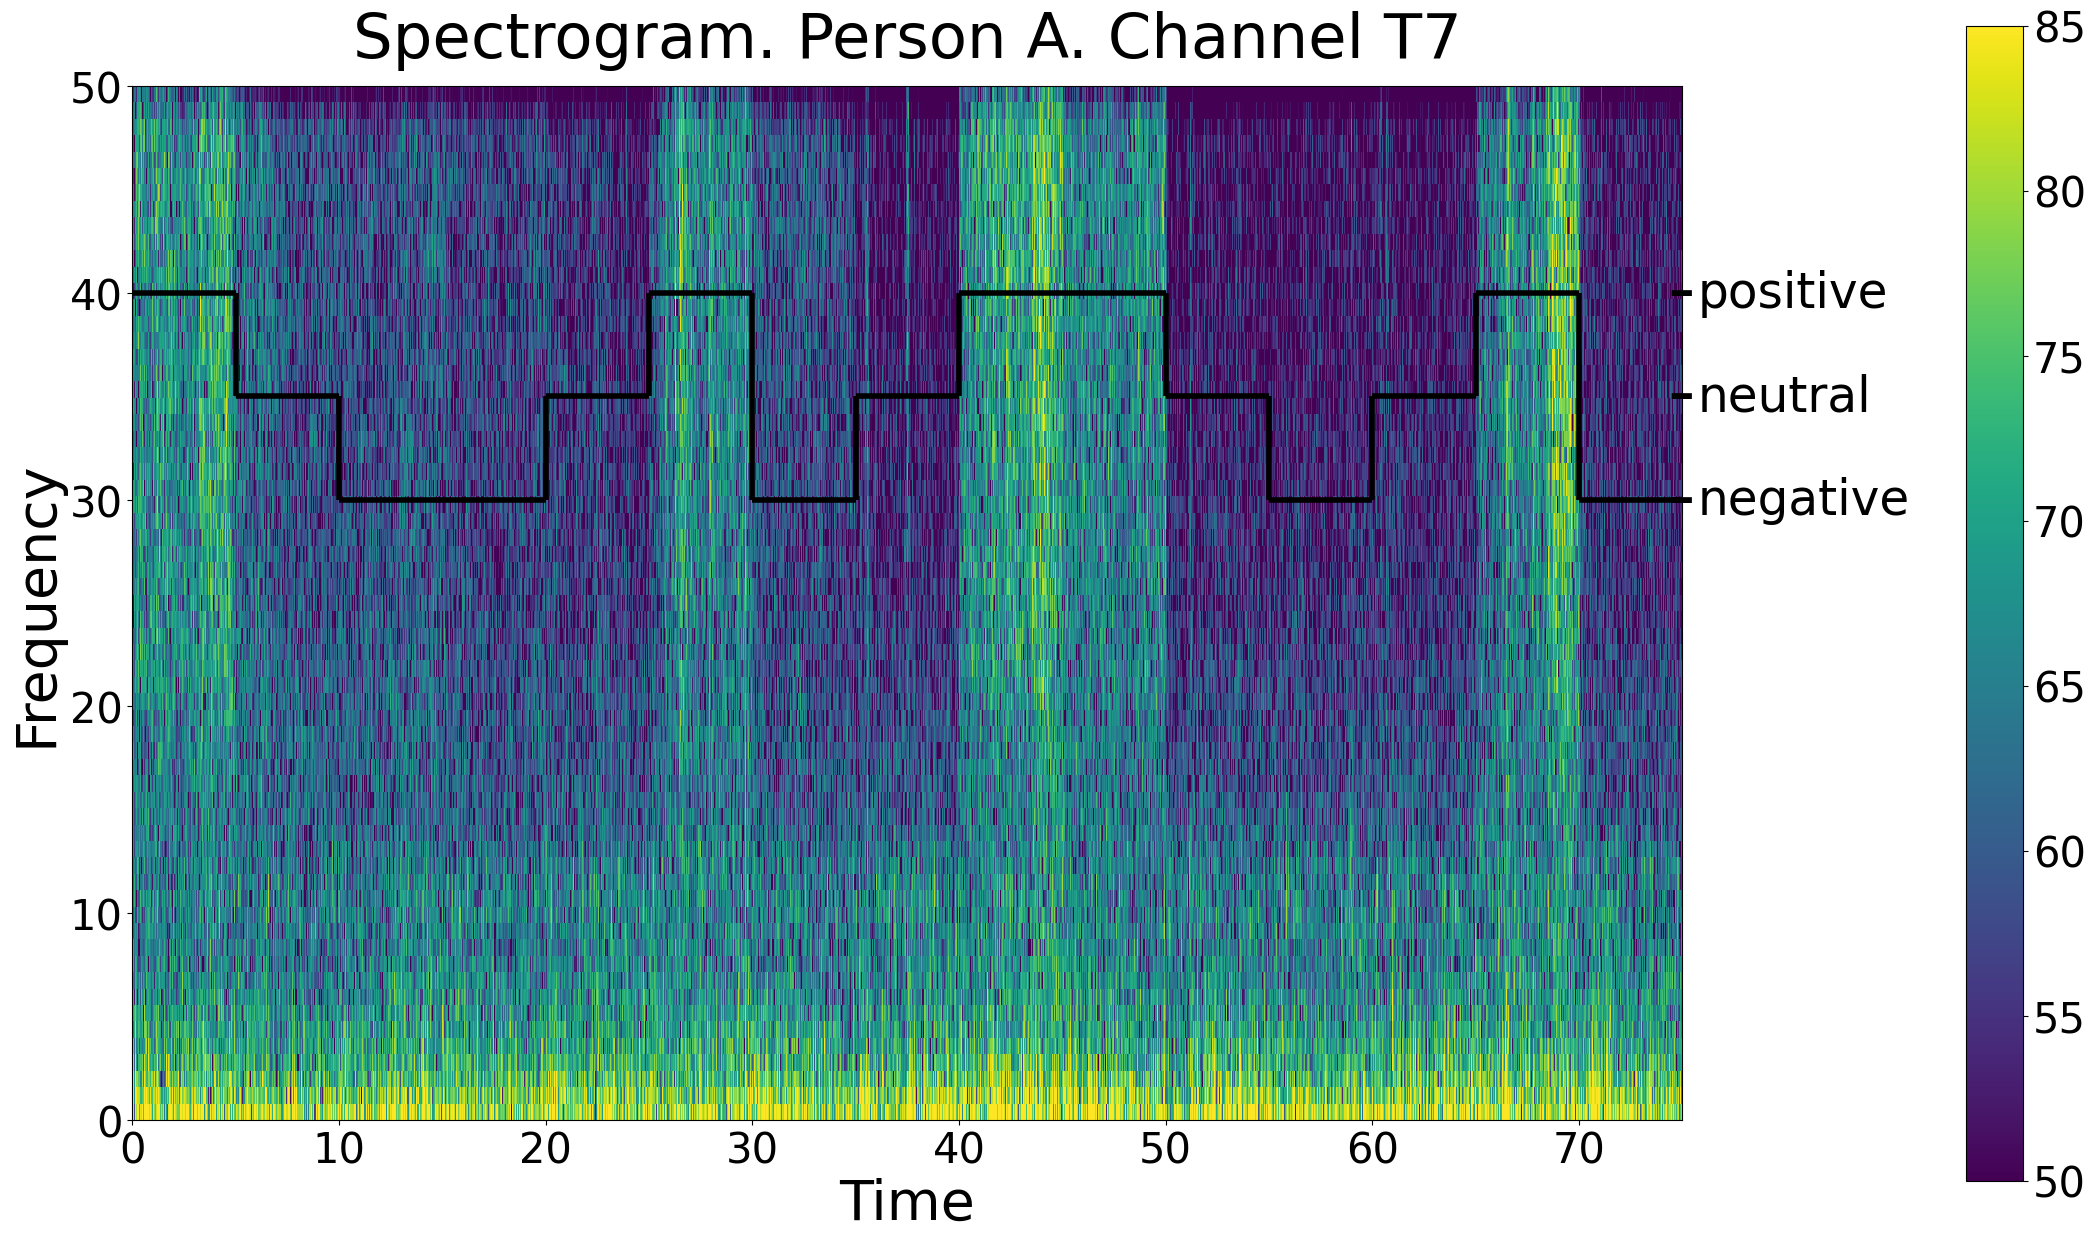

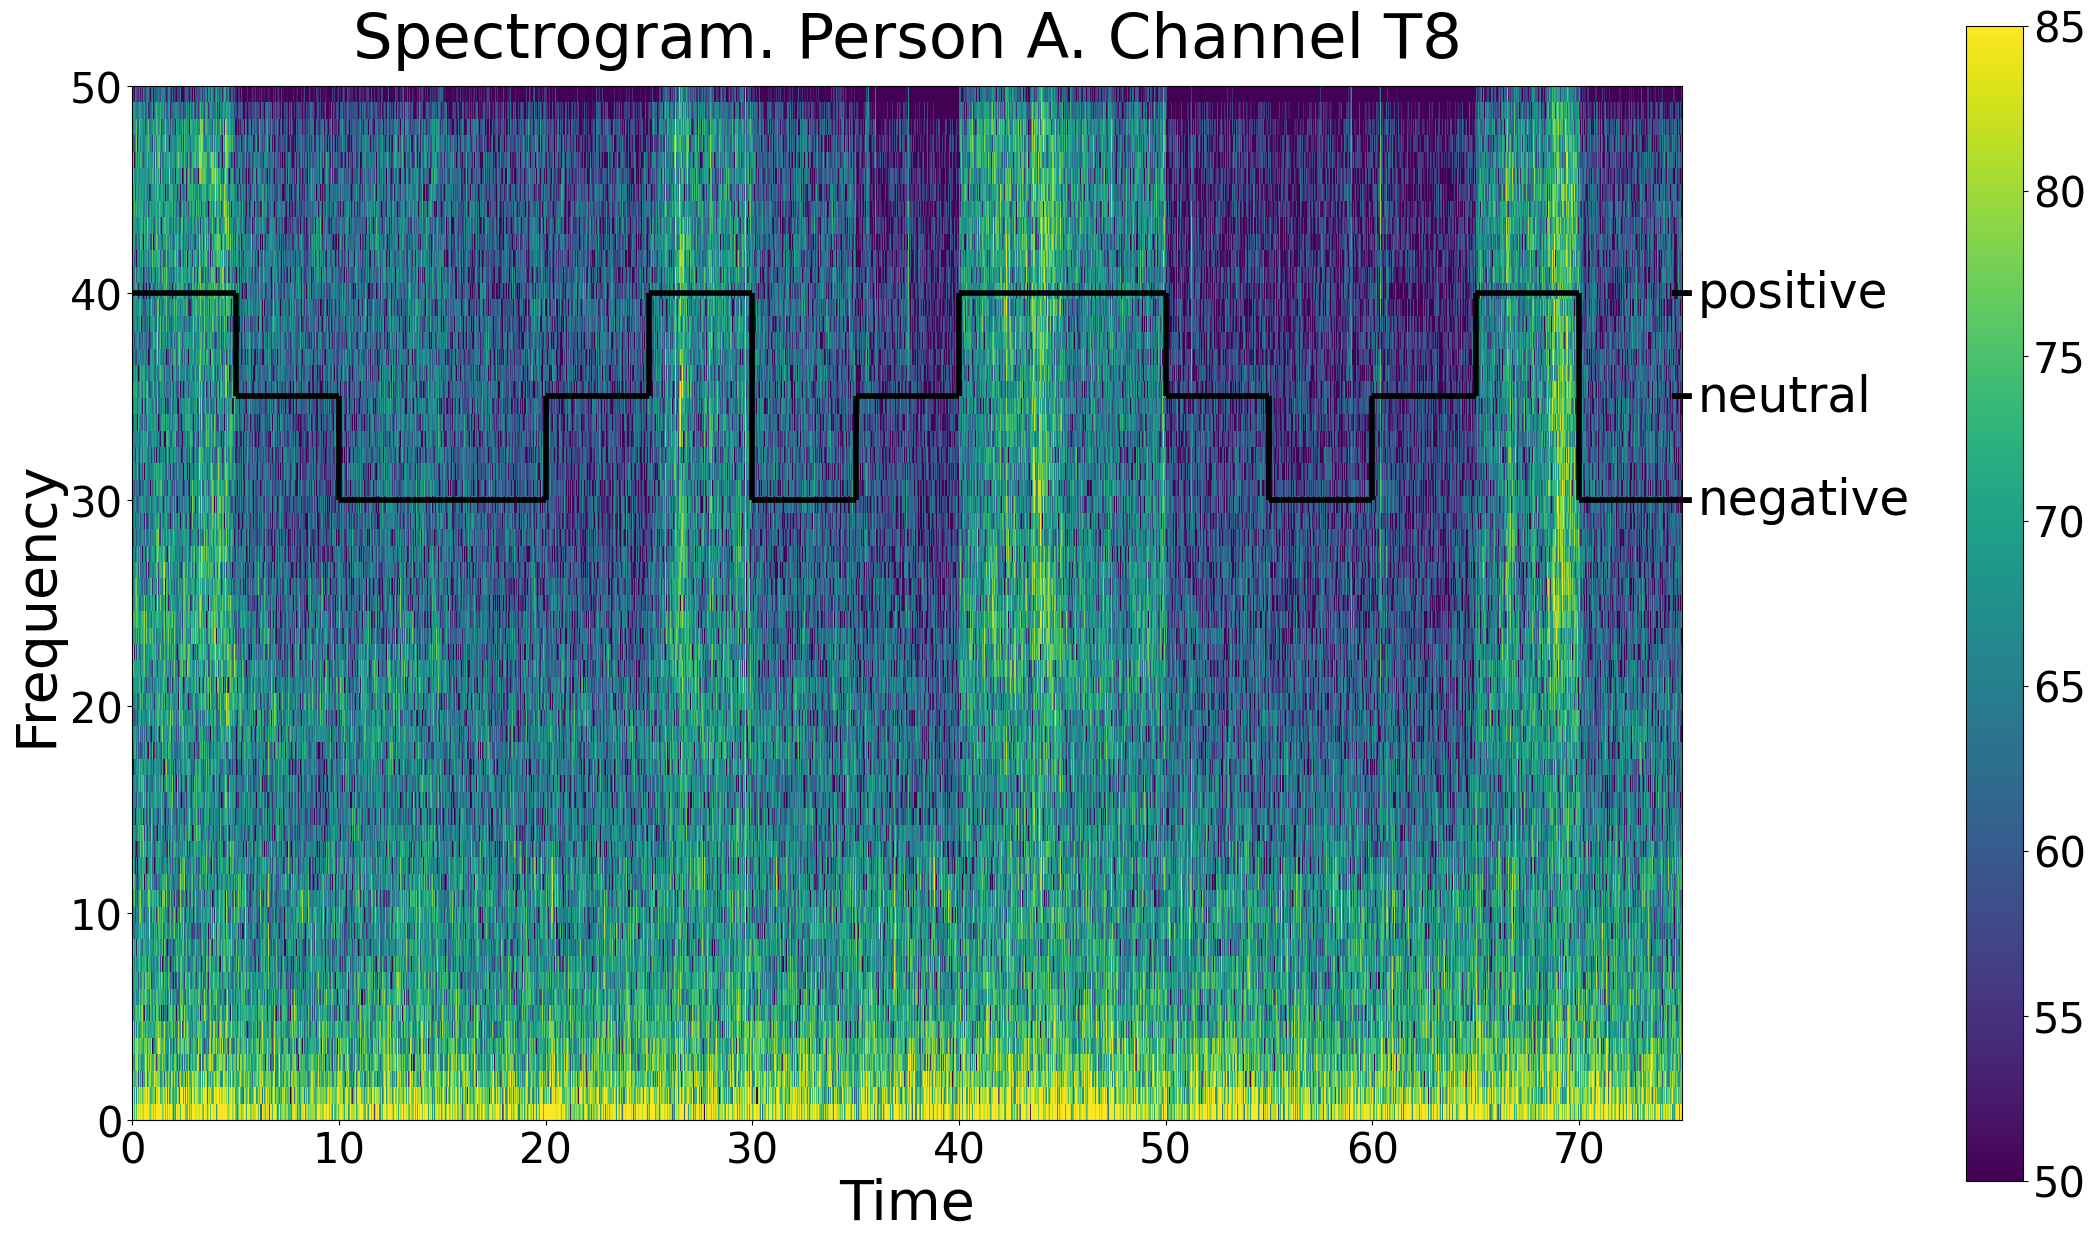

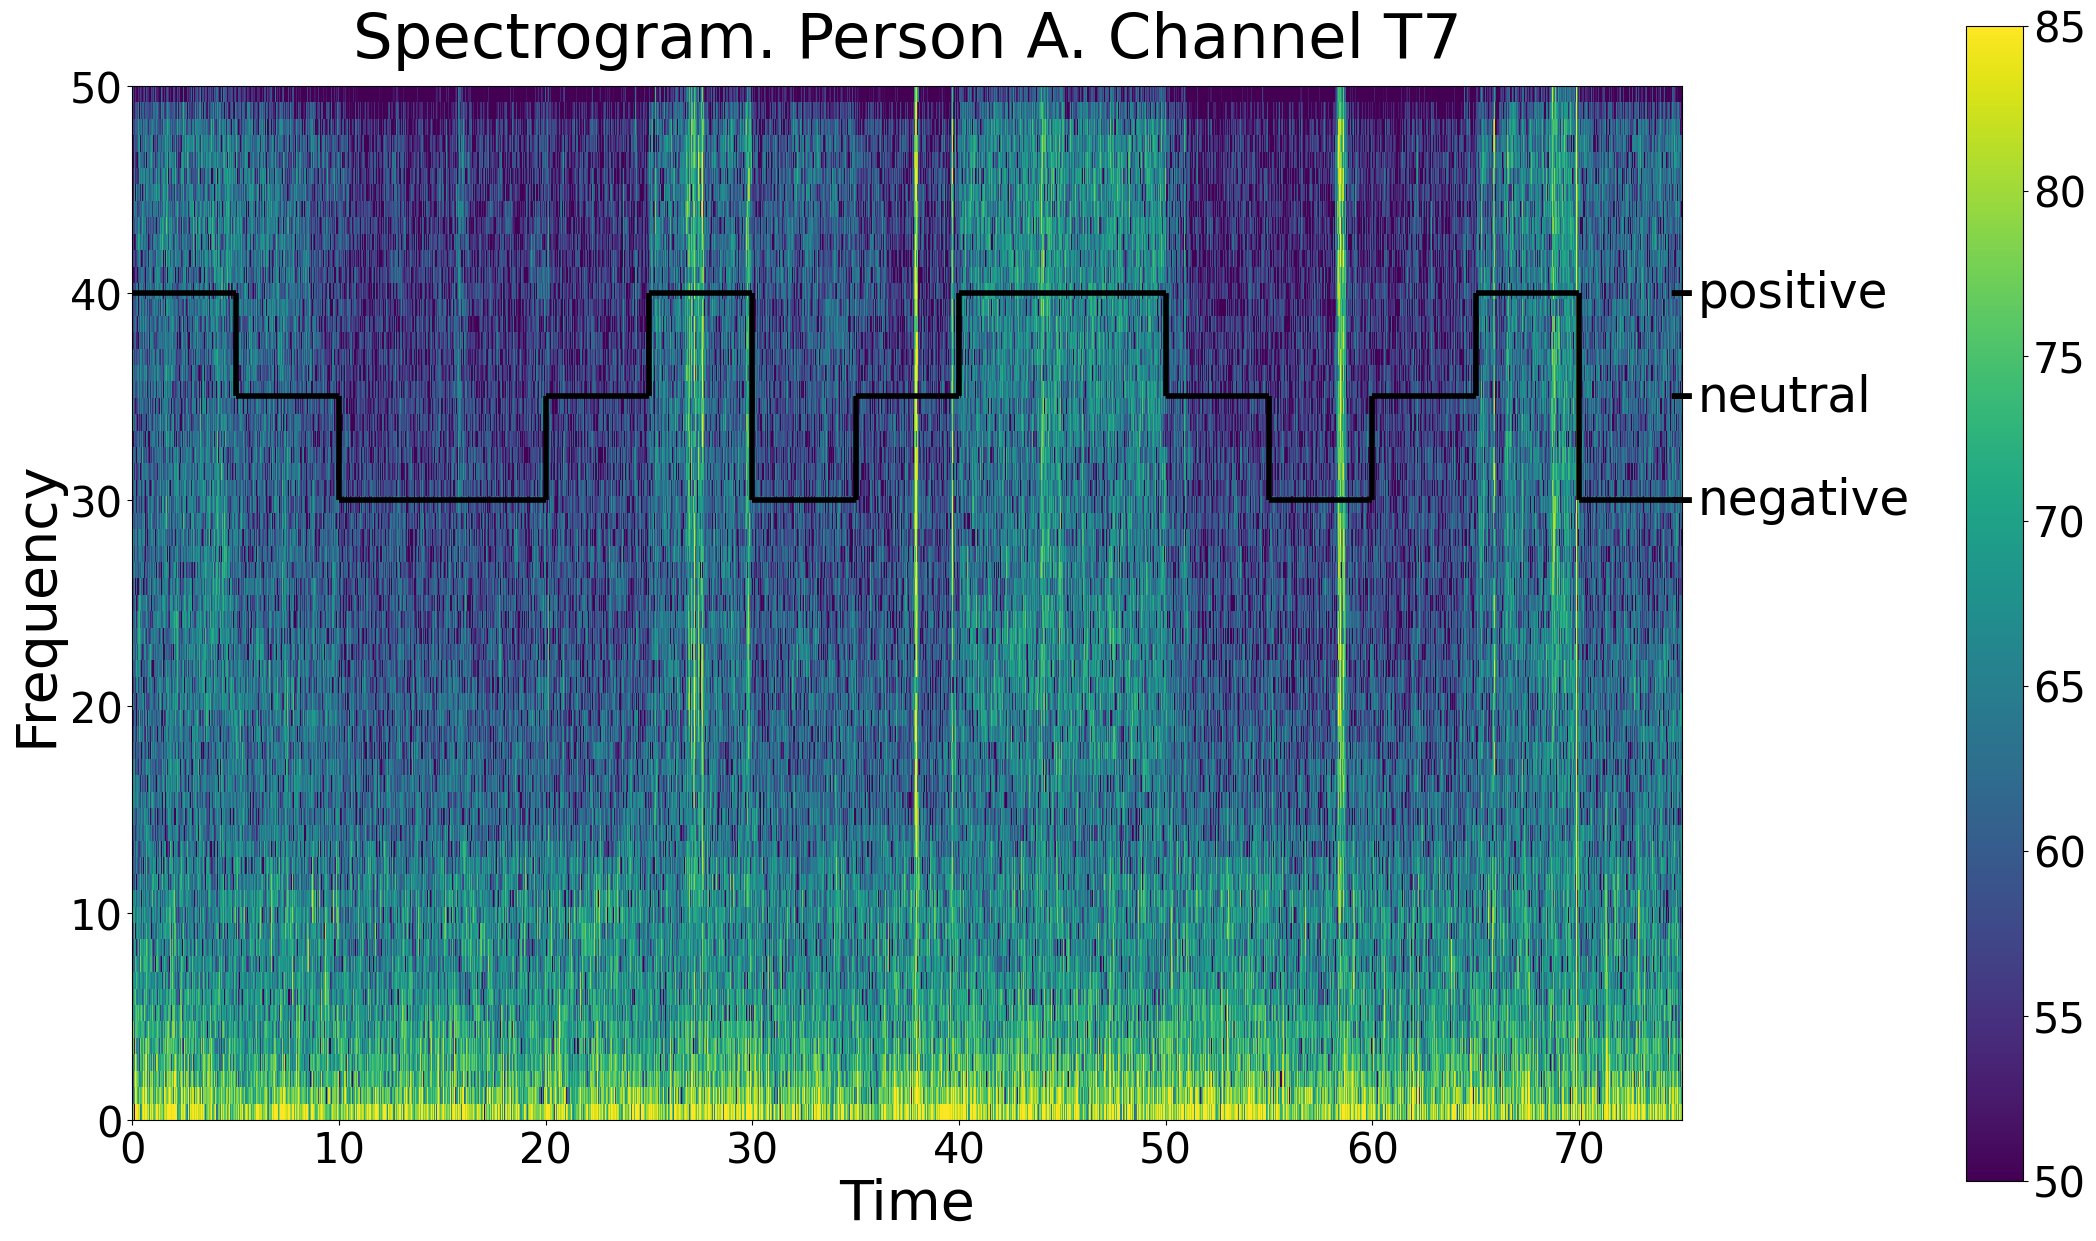

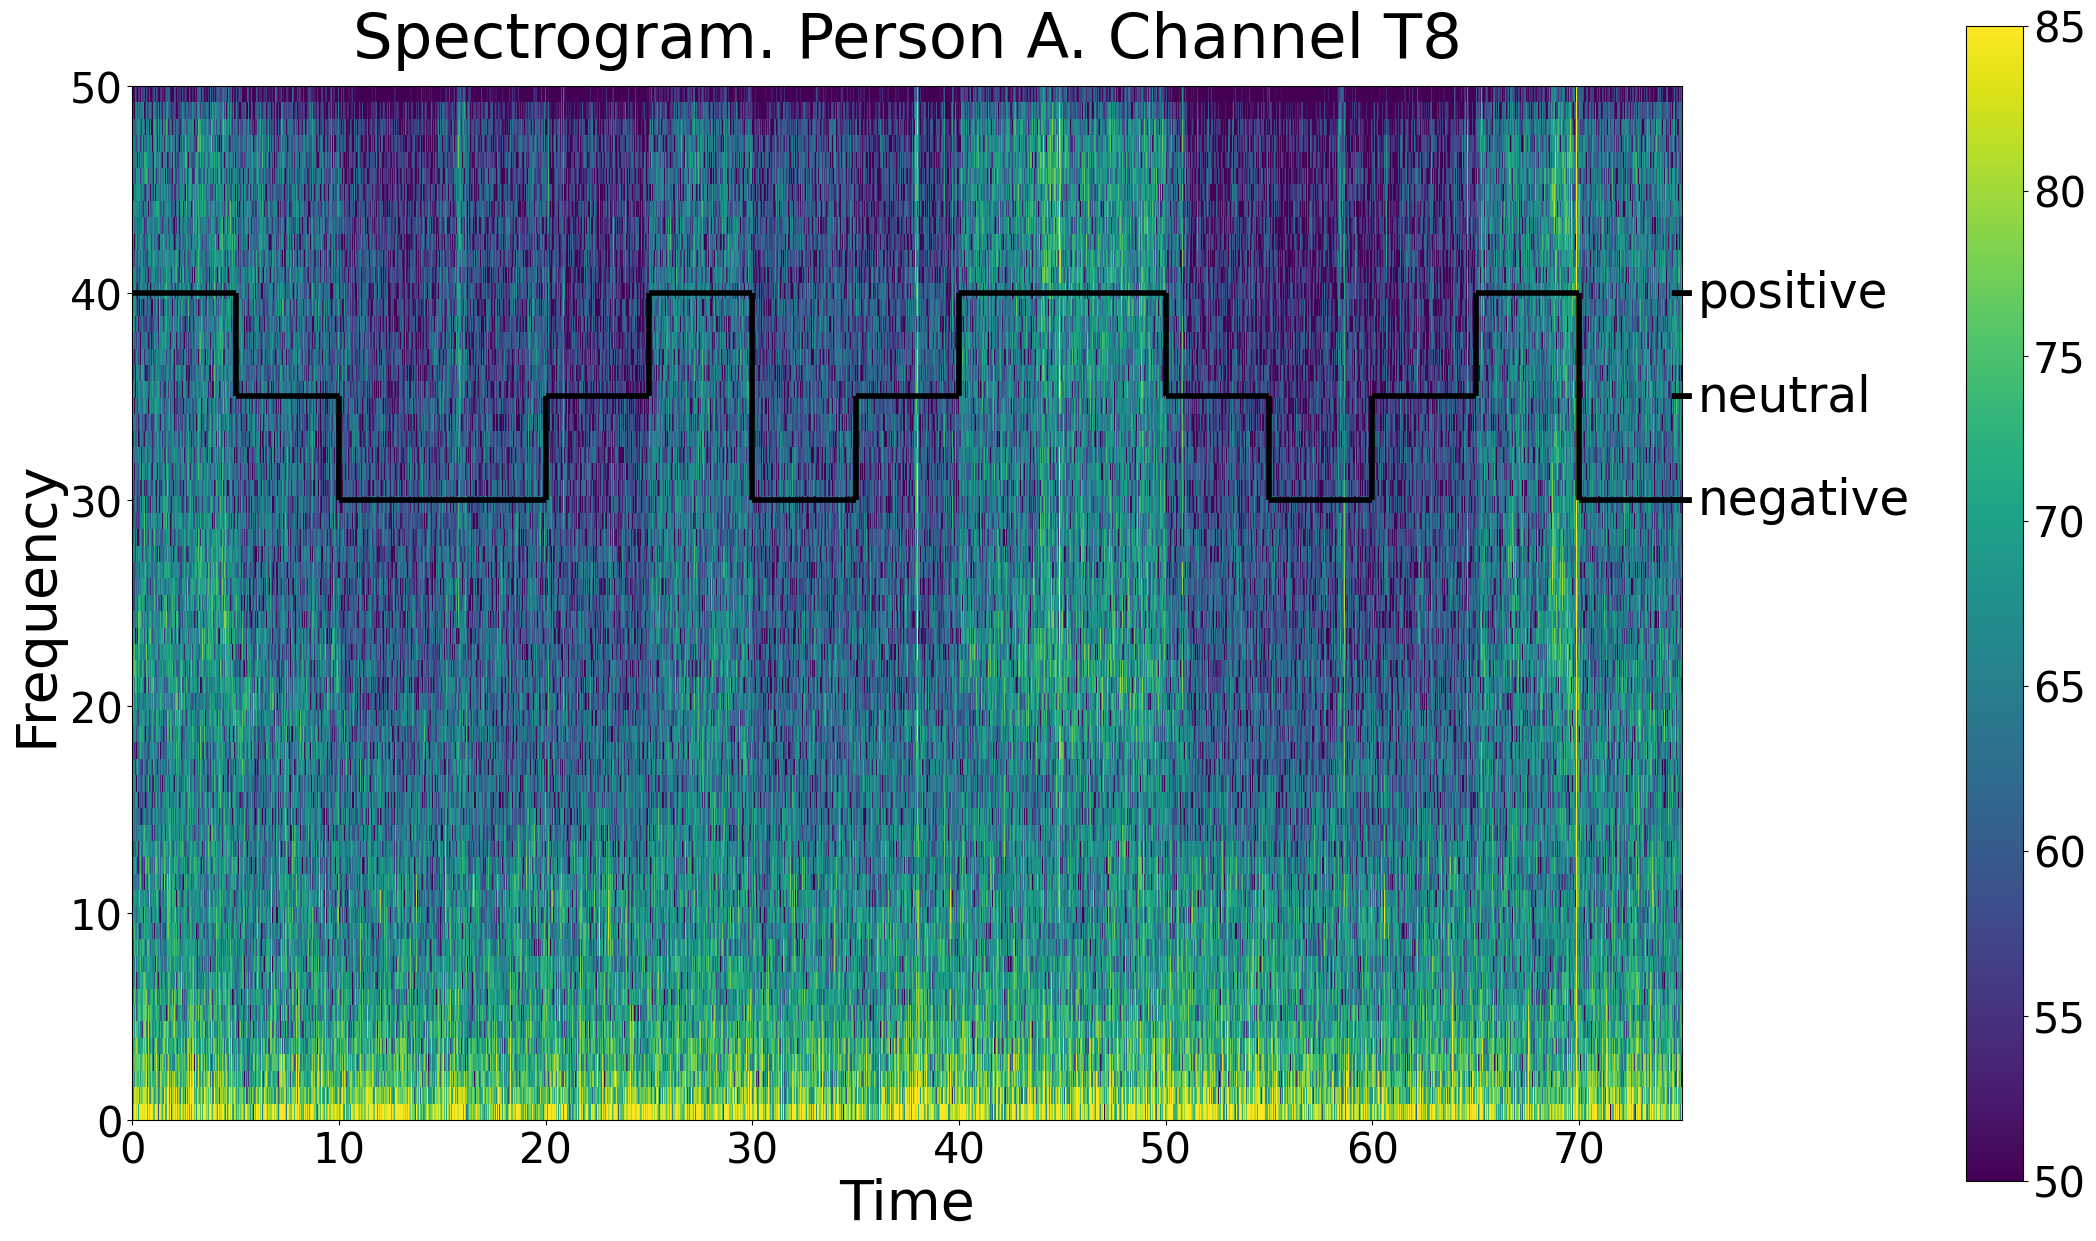

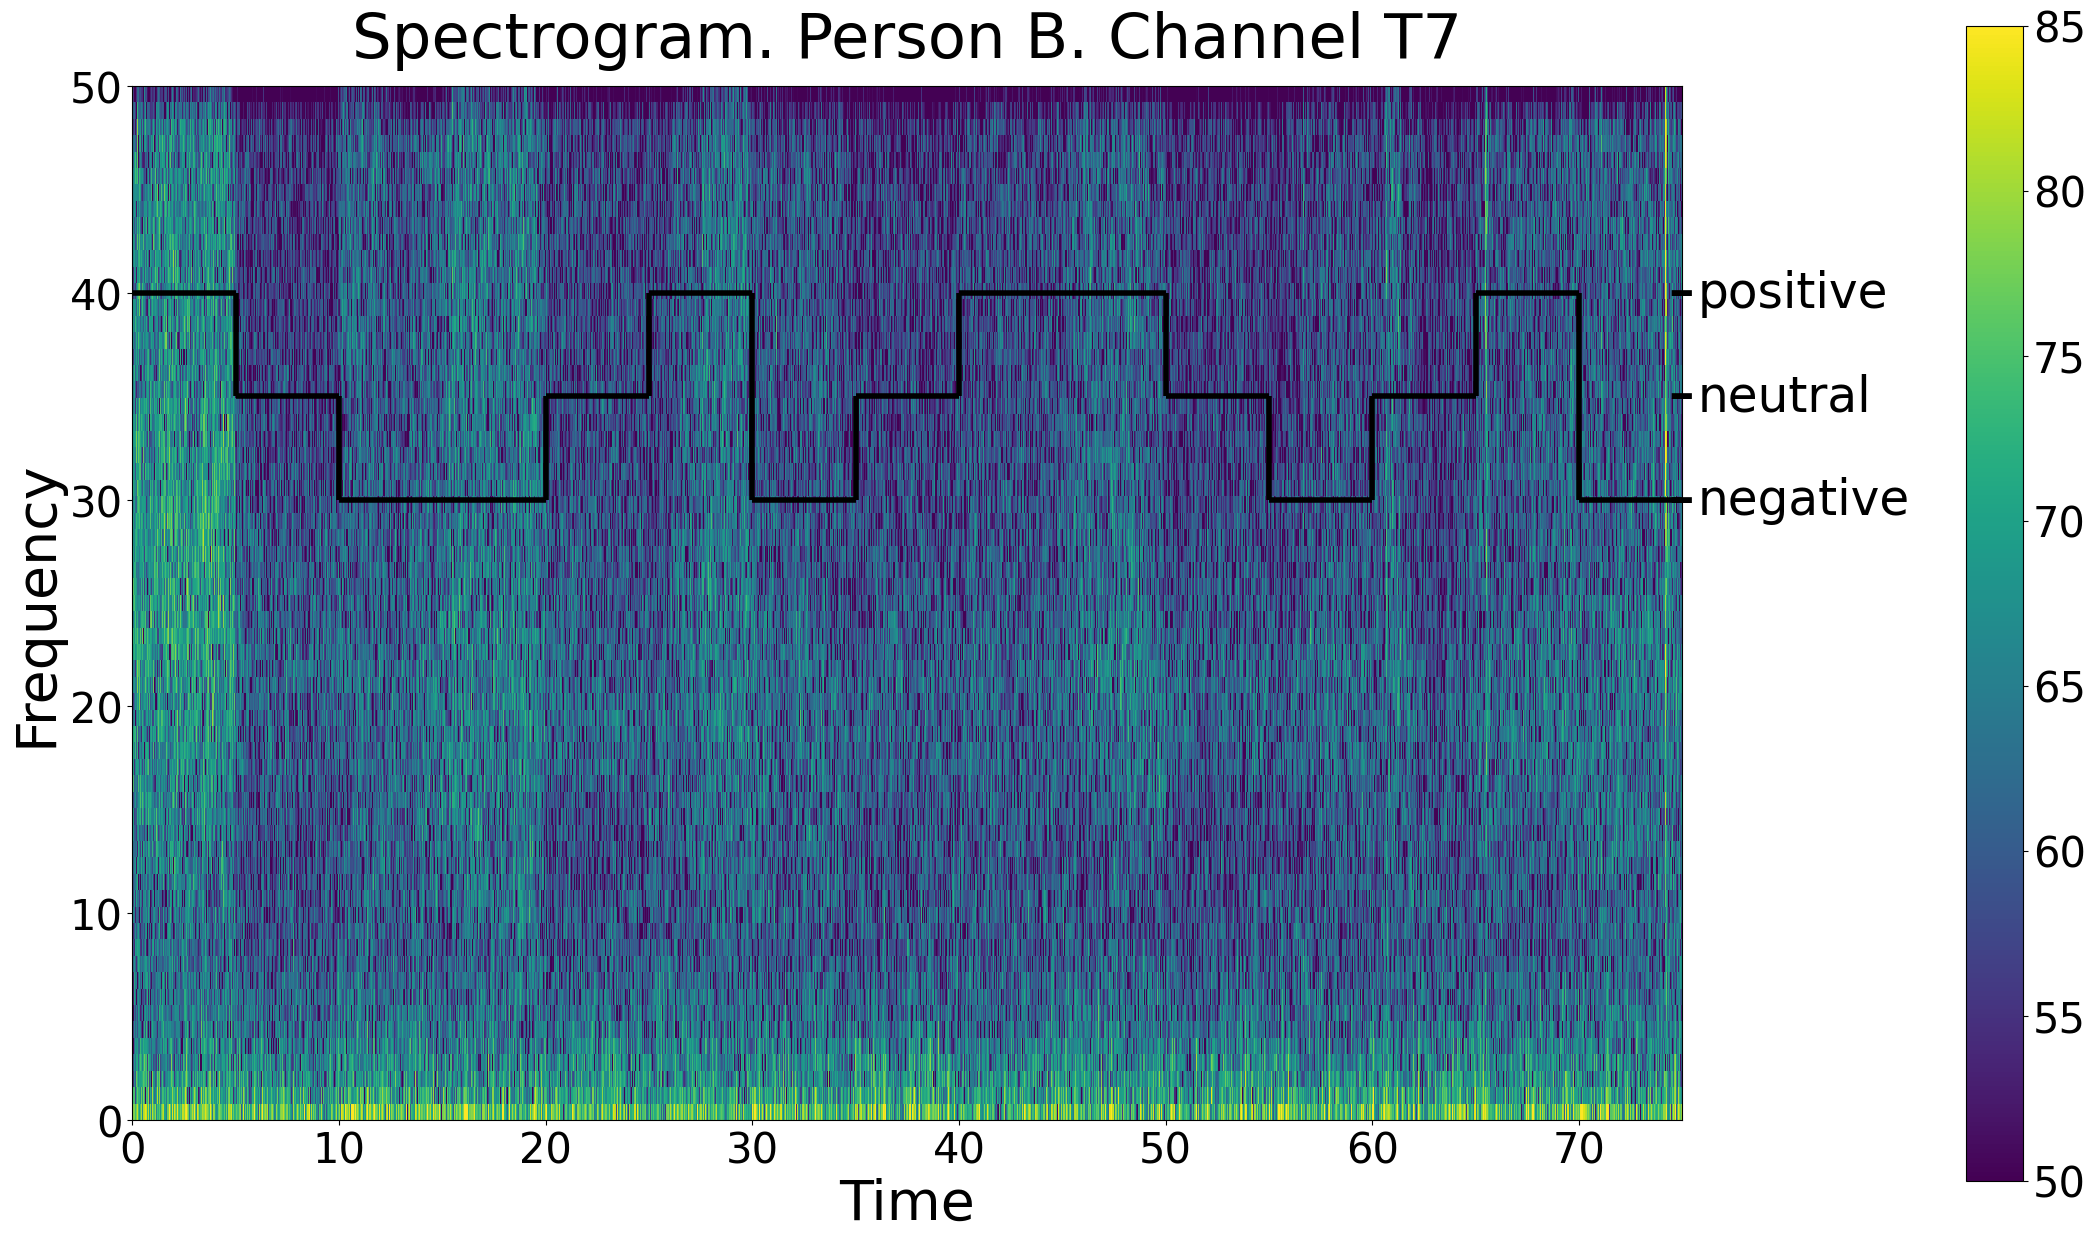

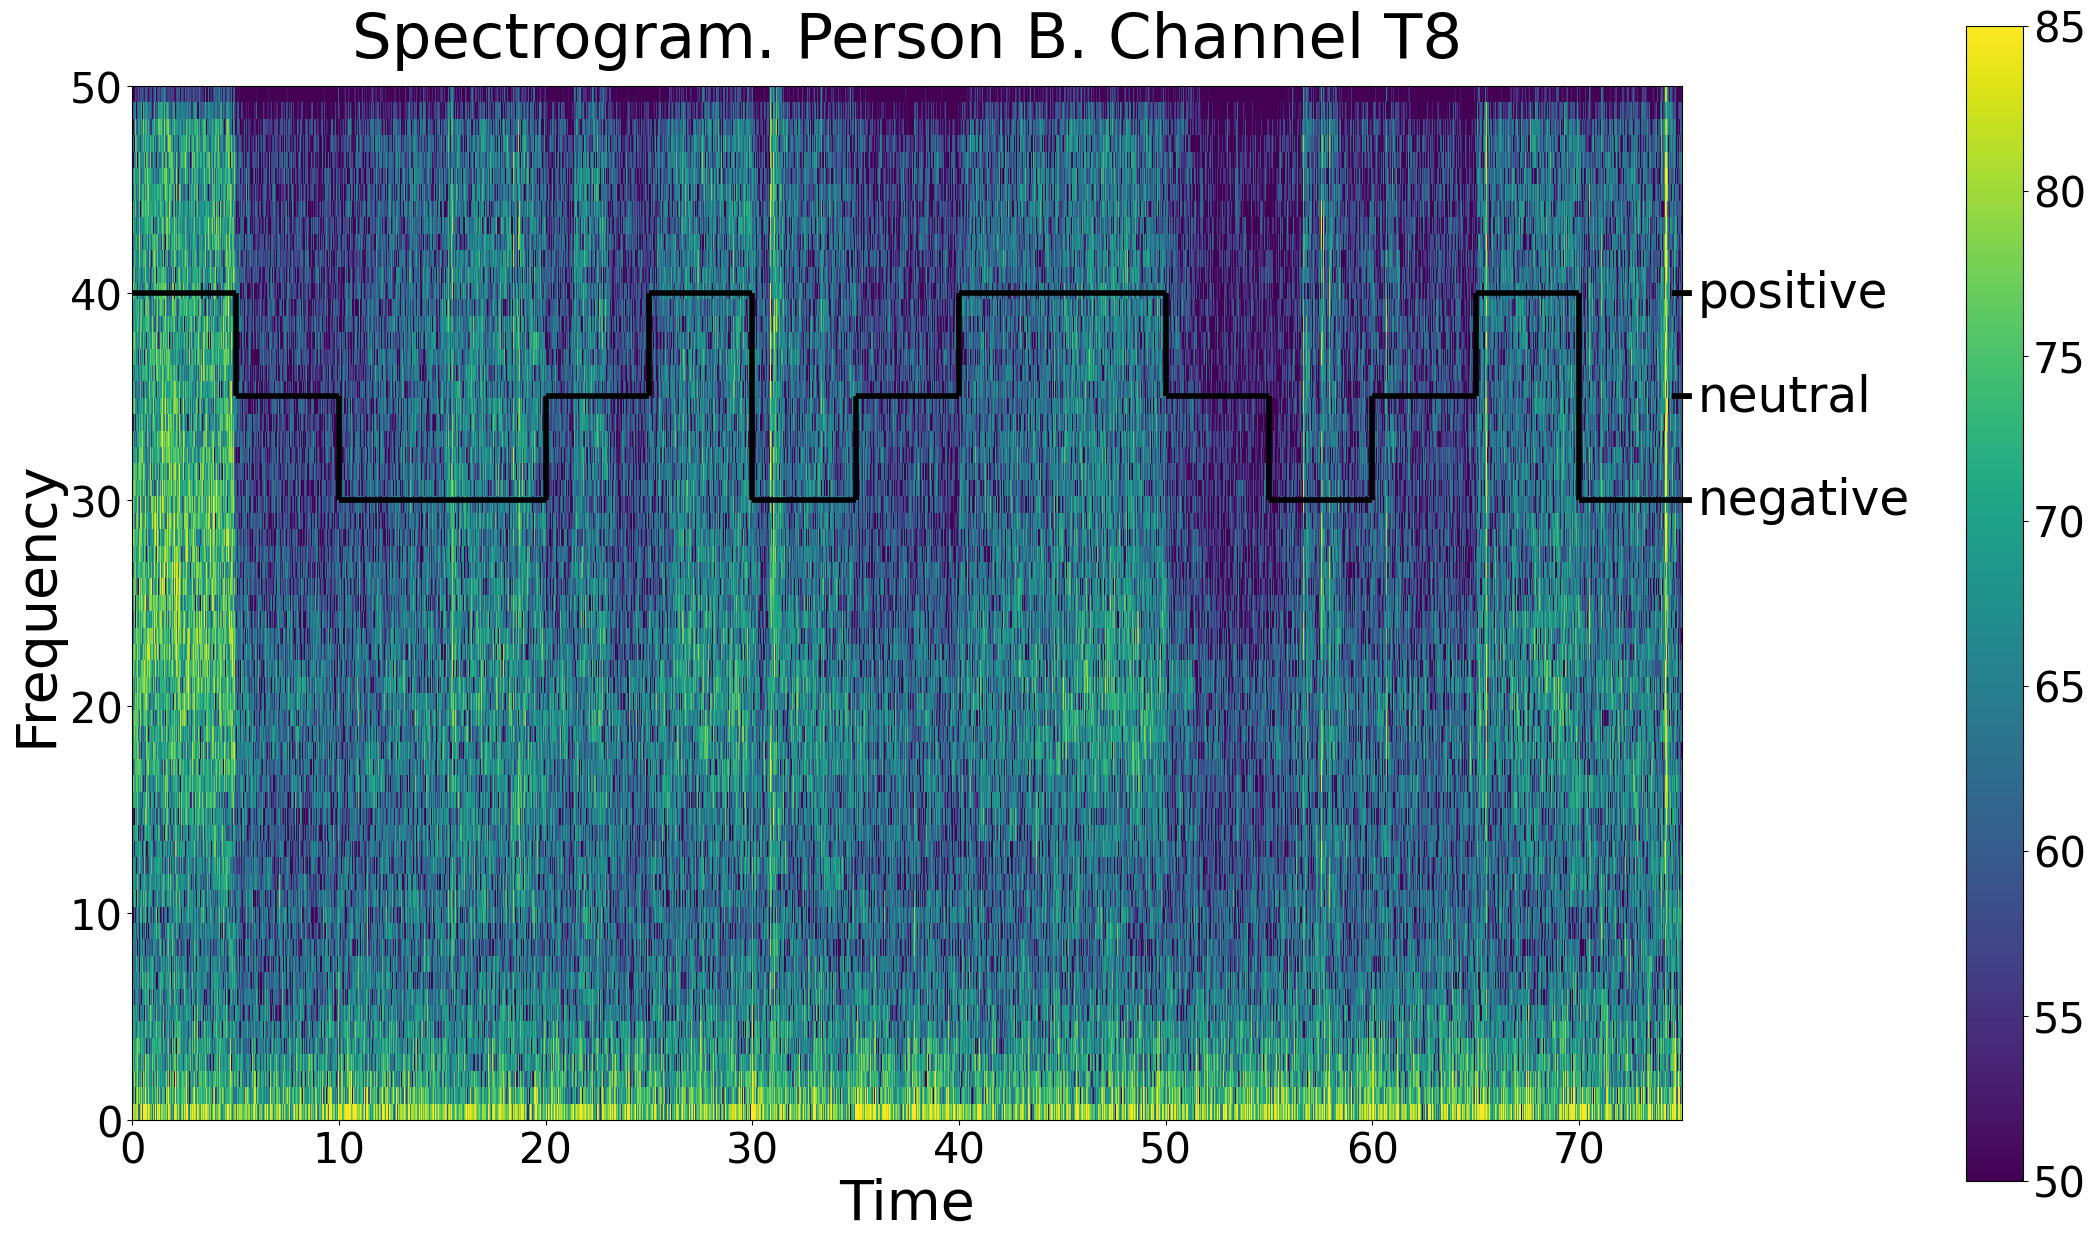

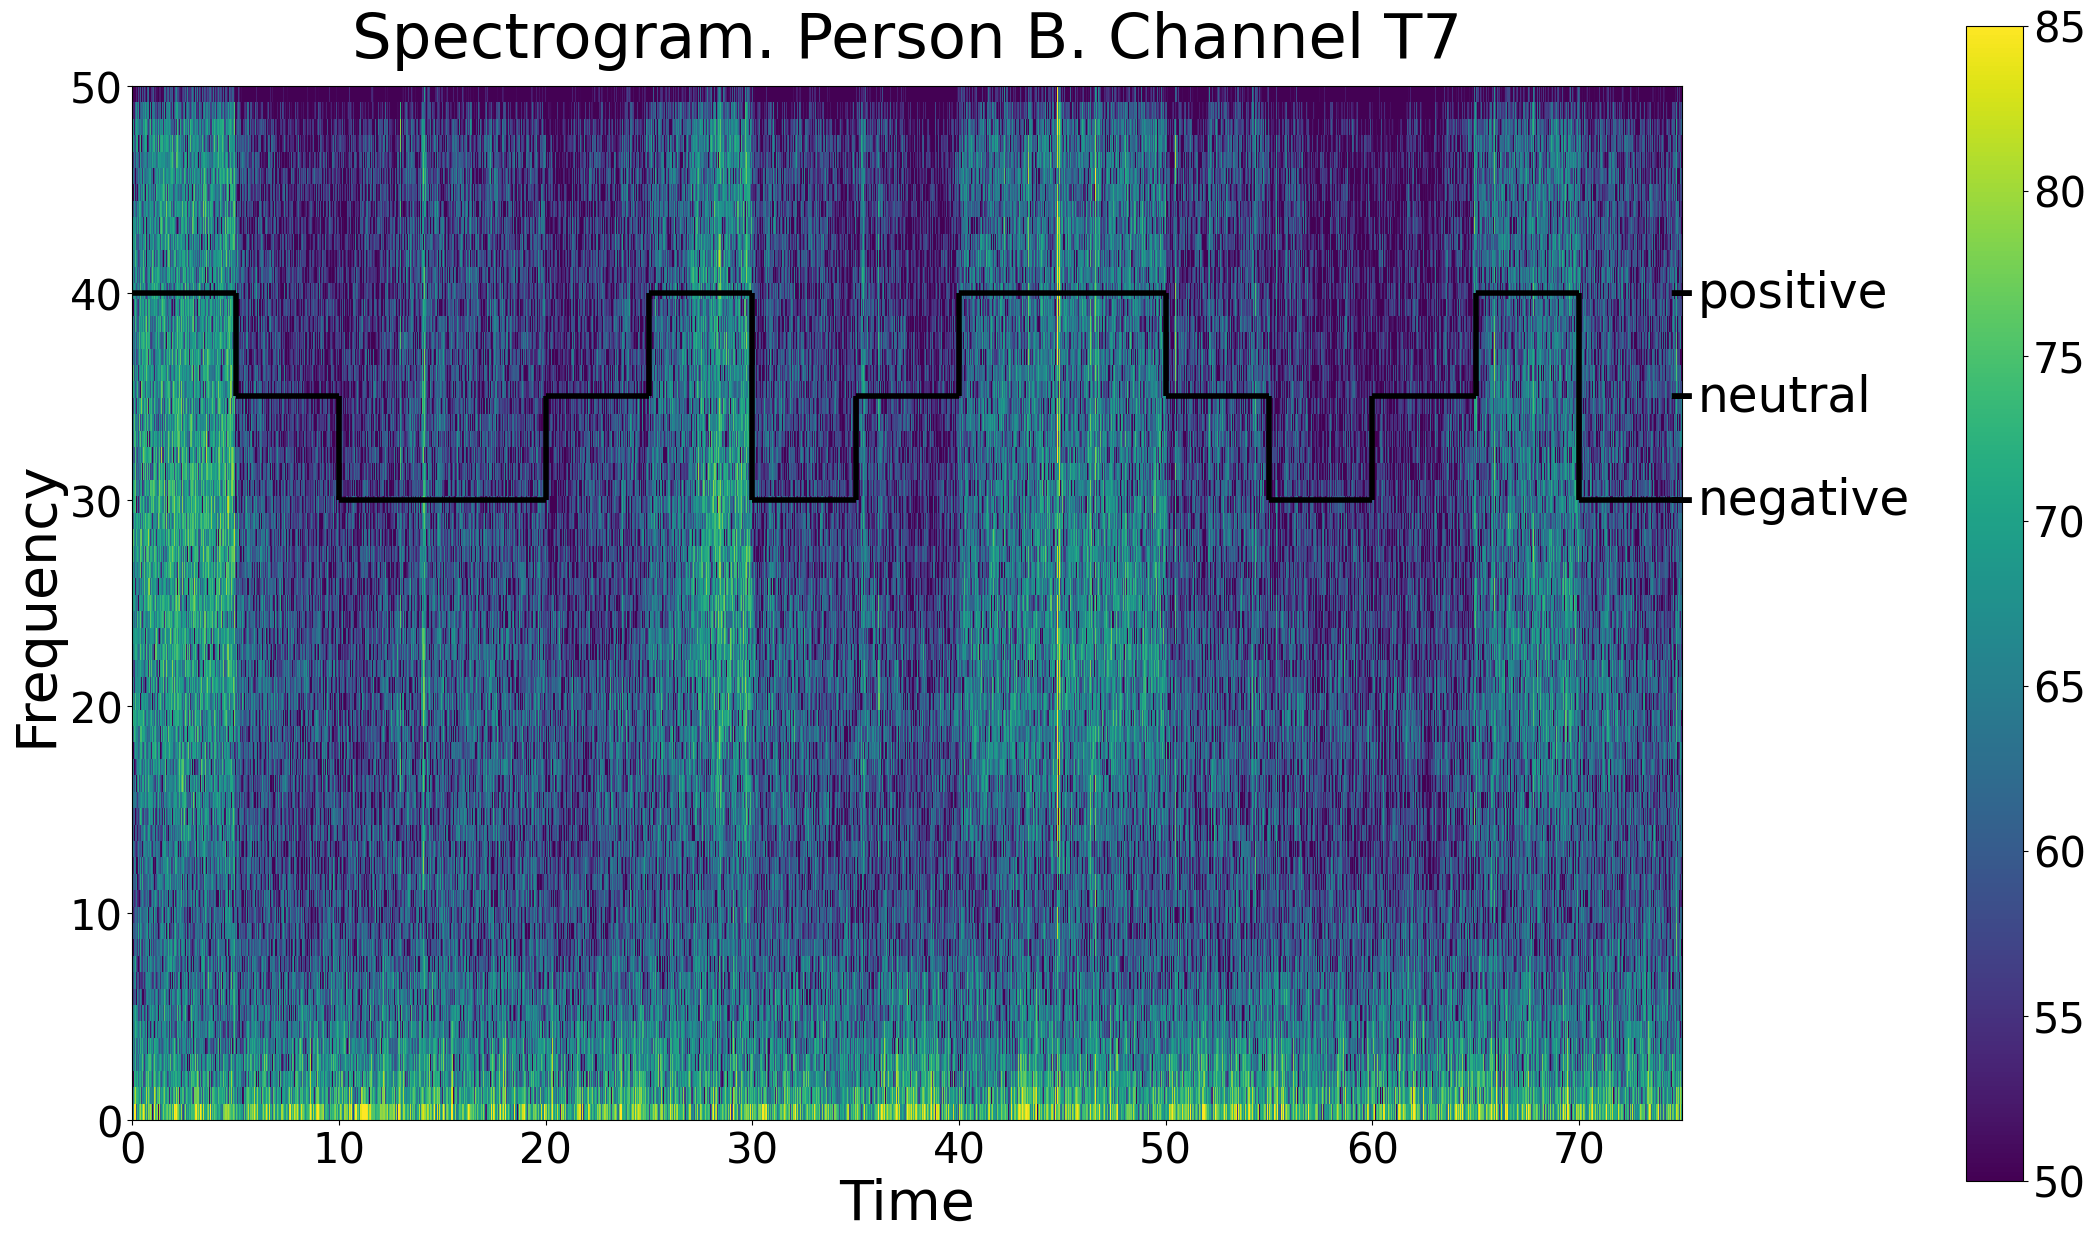

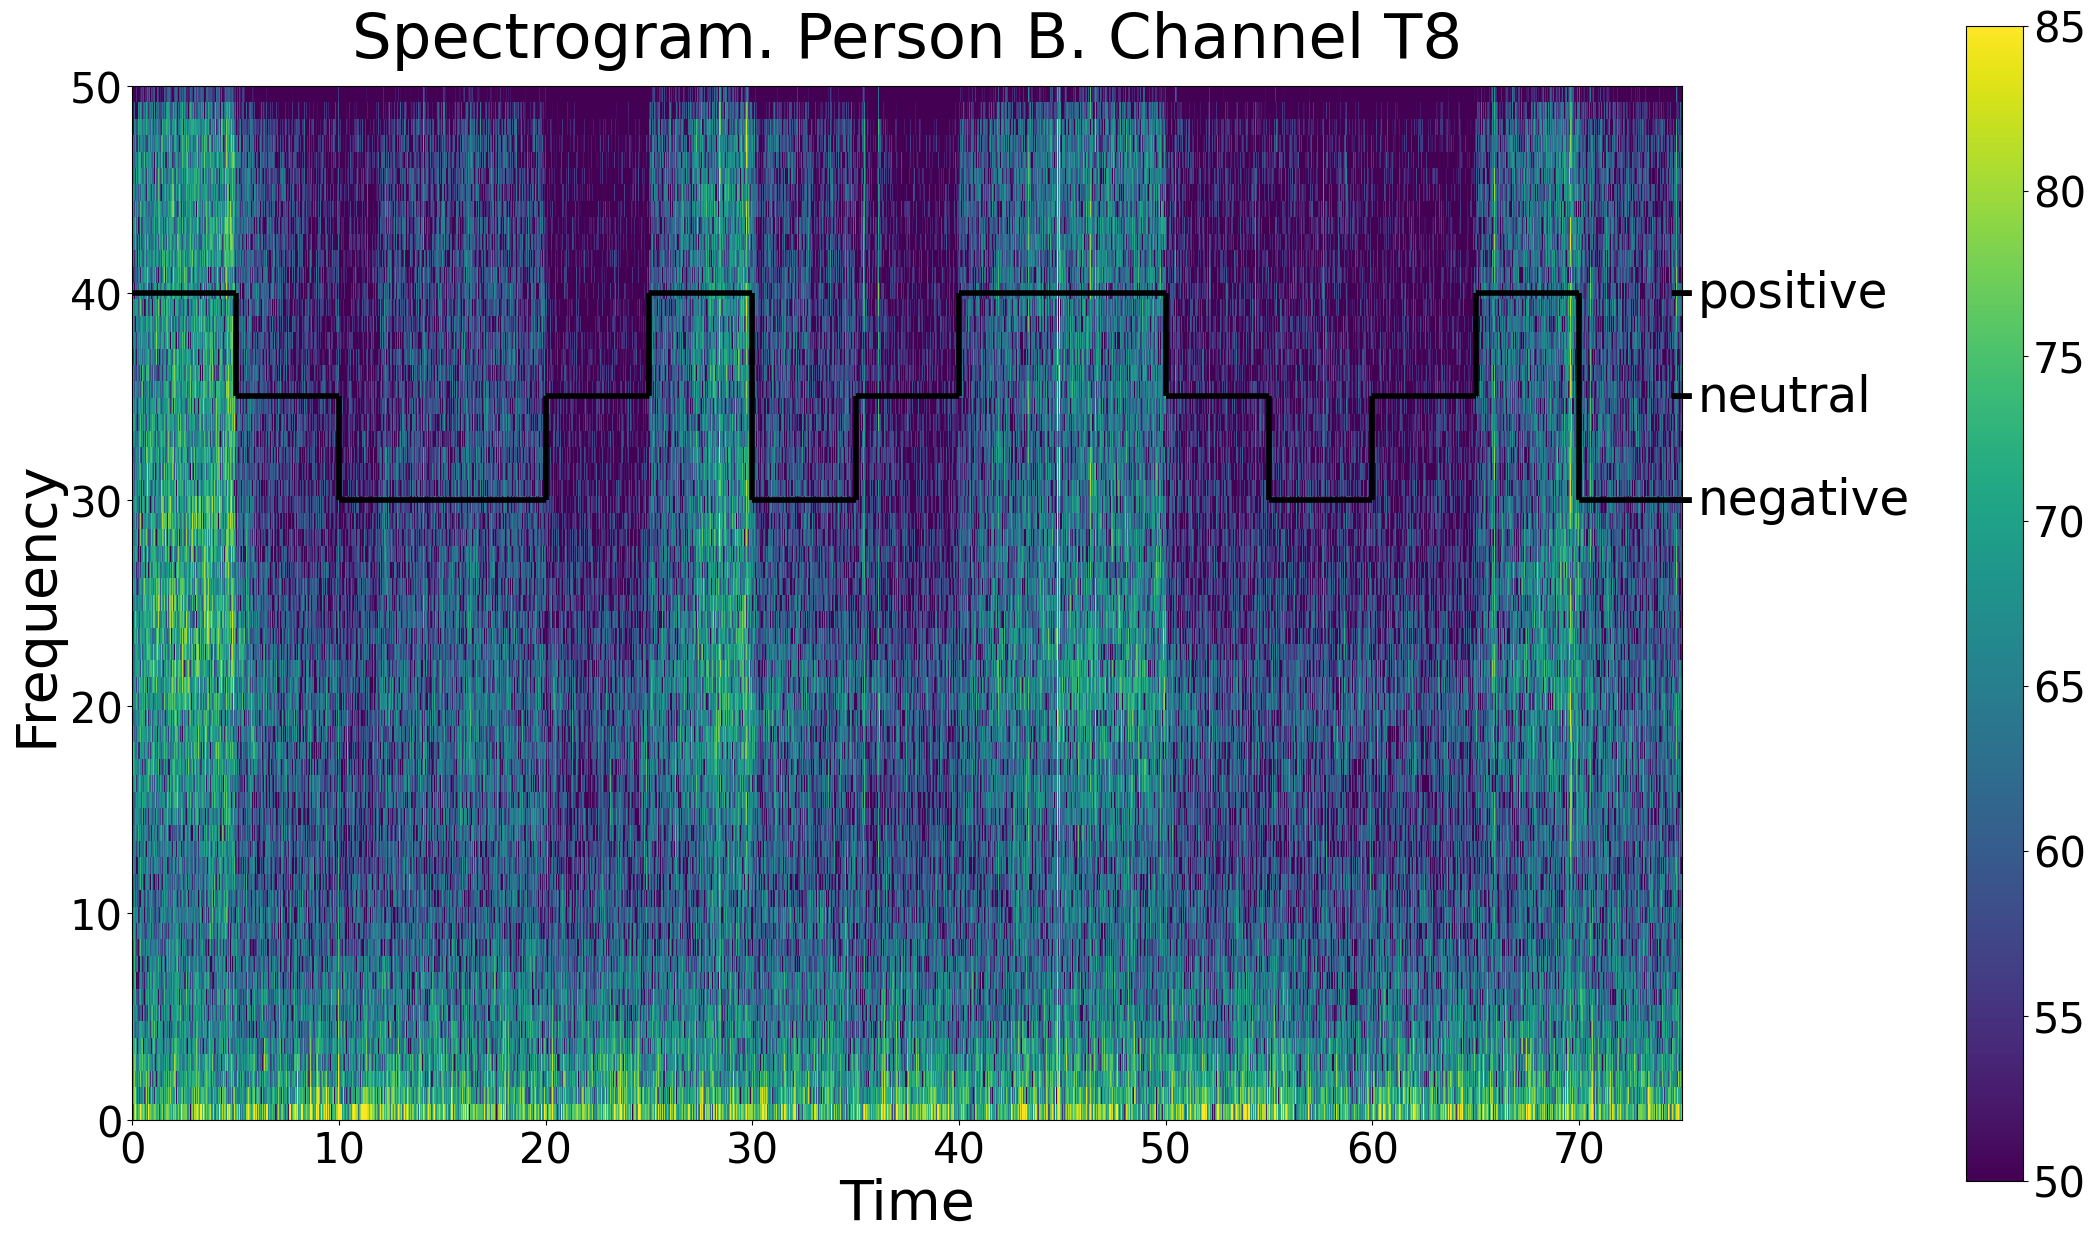

In [ ]:
specgram_jigsaw_seed(data_p1_t1, channels_order_seed, "T7", p = "A", baseline = 35, linewidths = 4)
specgram_jigsaw_seed(data_p1_t1, channels_order_seed, "T8", p = "A", baseline = 35, linewidths = 4)

specgram_jigsaw_seed(data_p1_t2, channels_order_seed, "T7", p = "A", baseline = 35, linewidths = 4)
specgram_jigsaw_seed(data_p1_t2, channels_order_seed, "T8", p = "A", baseline = 35, linewidths = 4)

specgram_jigsaw_seed(data_p2_t1, channels_order_seed, "T7", p = "B", baseline = 35, linewidths = 4)
specgram_jigsaw_seed(data_p2_t1, channels_order_seed, "T8", p = "B", baseline = 35, linewidths = 4)

specgram_jigsaw_seed(data_p2_t2, channels_order_seed, "T7", p = "B", baseline = 35, linewidths = 4)
specgram_jigsaw_seed(data_p2_t2, channels_order_seed, "T8", p = "B", baseline = 35, linewidths = 4)

### DEAP

In [ ]:
data_path_p1 = "/content/DEAP/s01.mat"
data_path_p2 = "/content/DEAP/s02.mat"

data_p1 = scipy.io.loadmat(data_path_p1)
data_p2 = scipy.io.loadmat(data_path_p2)

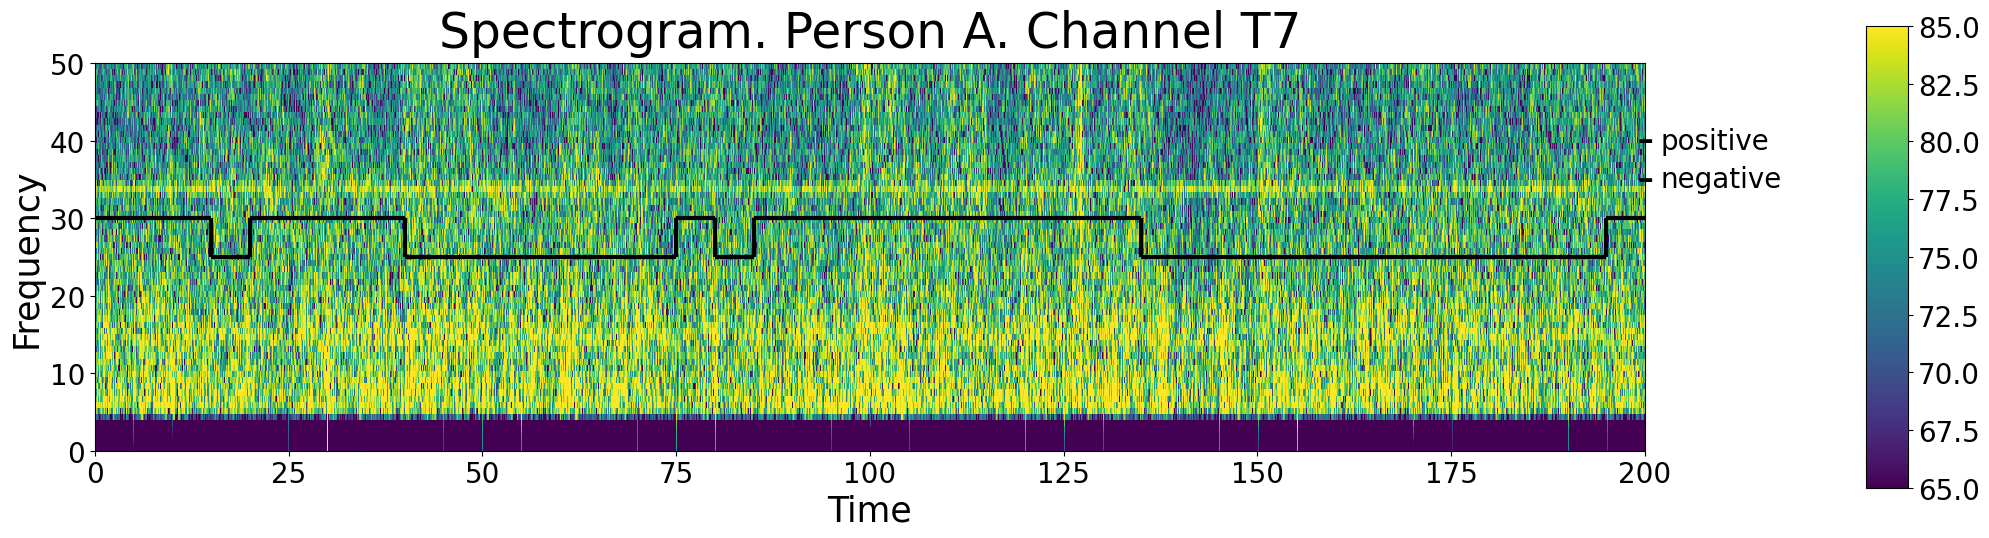

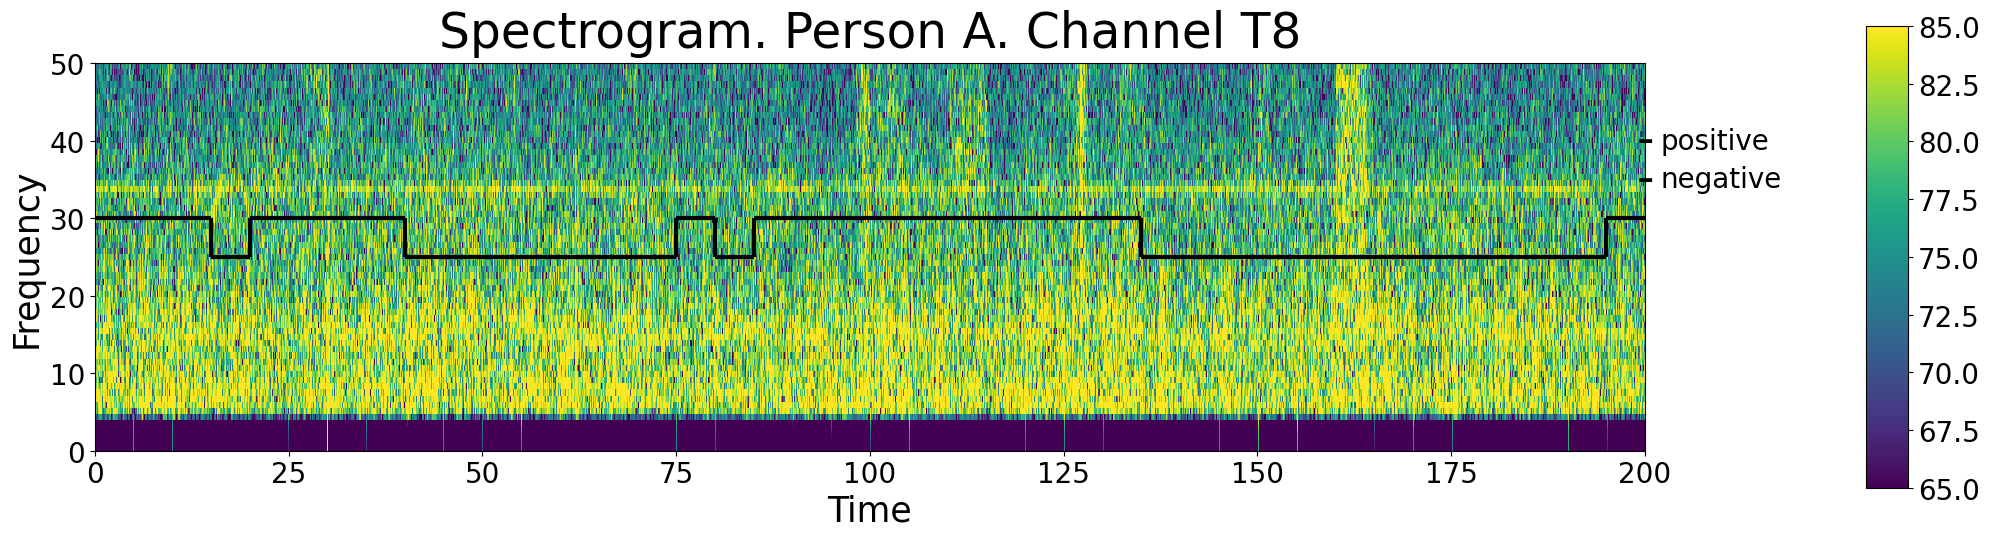

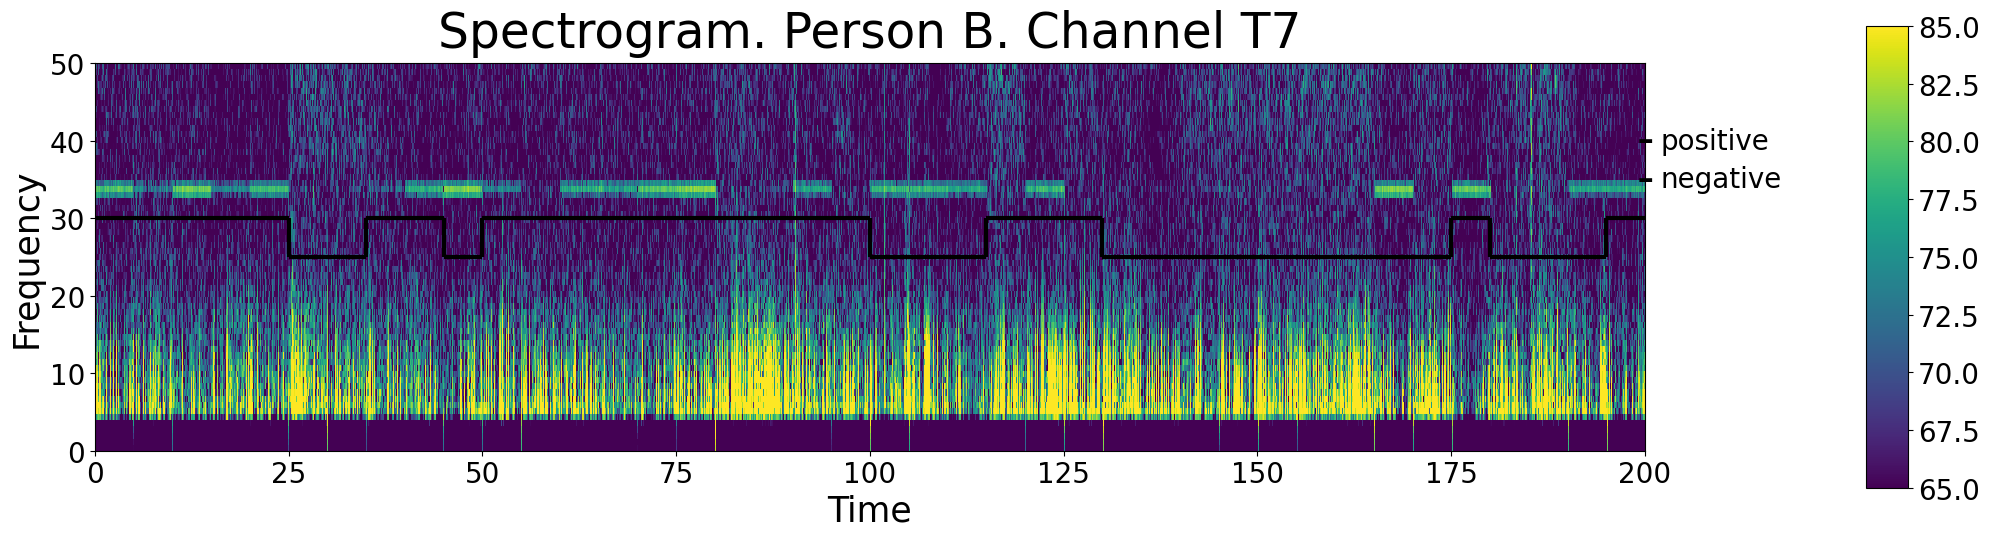

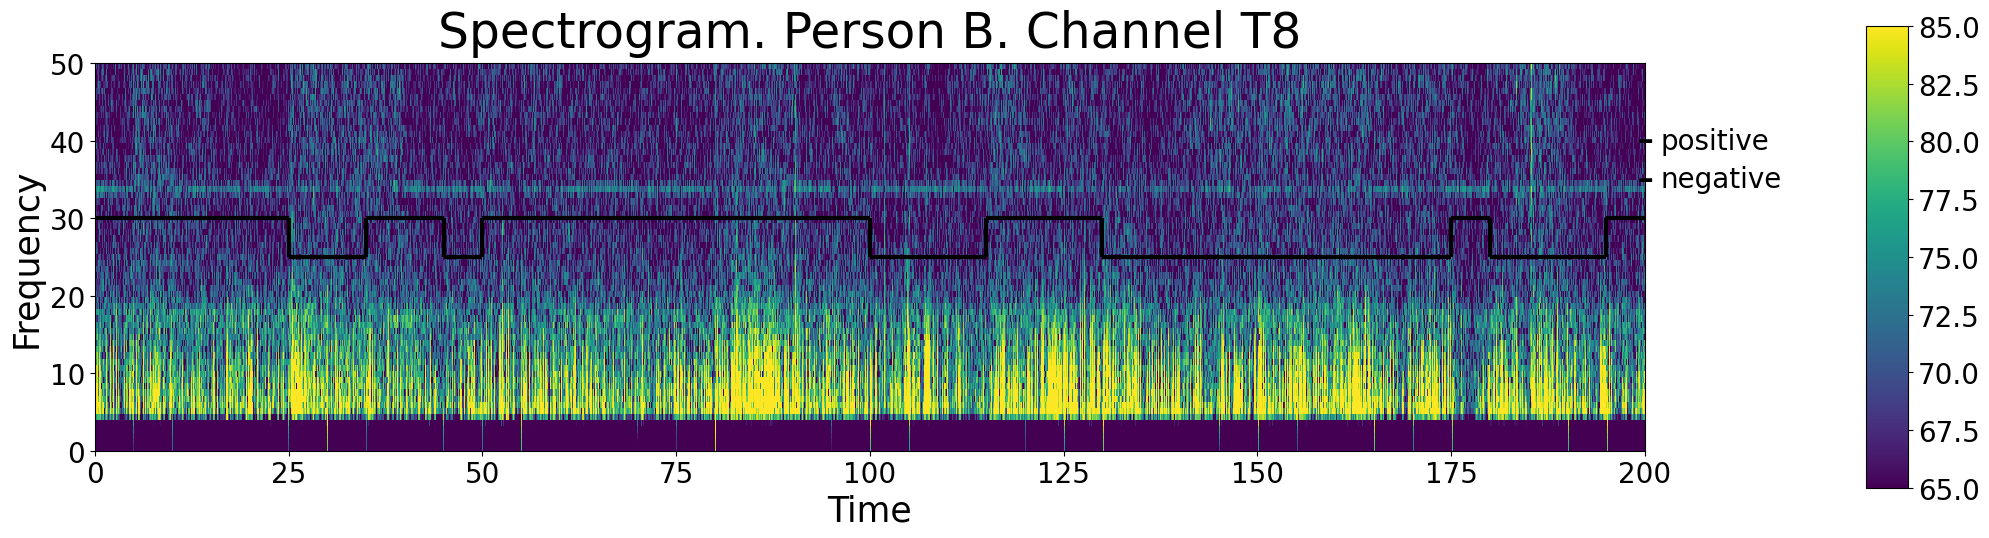

In [ ]:
specgram_jigsaw_deap(data_p1, channels_order_deap, "T7", p = "A", baseline = 25, linewidths = 3)
specgram_jigsaw_deap(data_p1, channels_order_deap, "T8", p = "A", baseline = 25, linewidths = 3)

specgram_jigsaw_deap(data_p2, channels_order_deap, "T7", p = "B", baseline = 25, linewidths = 3)
specgram_jigsaw_deap(data_p2, channels_order_deap, "T8", p = "B", baseline = 25, linewidths = 3)

### PSD

Визуализация PSD для двух субъектов для одинковых эмоциональных состояний показала различные графики.

In [ ]:
# Also, you could ask authors for samples of preprocessed data.
# To use it, please, add the given folder to the root of your drive as a shortcut

from google.colab import drive
drive.mount("/content/drive")
!cp -r /content/drive/MyDrive/EEG_Dataset /content/SCLCM/src/

from data.general.metadata import general_metadata, datasets_metadata
selection = "seed_psd"
dataset_metadata = datasets_metadata[selection]
channels_cut = None
from data.general.load_any_data import load_data_by_selection
res = load_data_by_selection(selection, general_metadata, dataset_metadata, channels_cut)
data, session_labels, pid_video, num_video, subj_list, video_list, channels, need_norm, in_channels, in_features, num_classes, num_channels = res
data.shape

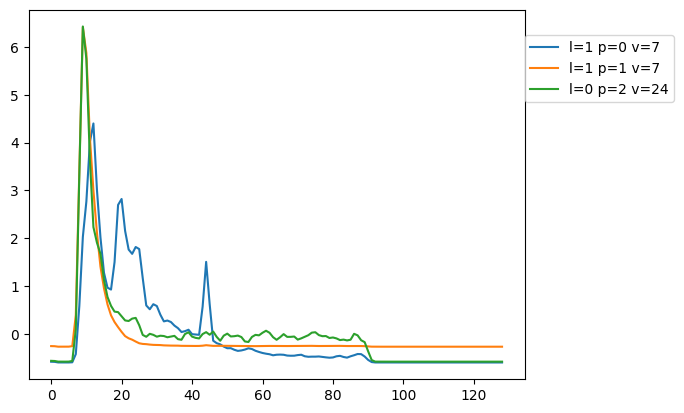

In [ ]:
# PSD
ind1 = 5
ind2 = 24
ind3 = 60

plt.plot(data[ind1, 0, 0], label=f"l={session_labels[ind1]} p={pid_video[ind1]  // num_video} v={pid_video[ind1] % num_video}")
plt.plot(data[ind2, 0, 0], label=f"l={session_labels[ind2]} p={pid_video[ind2] // num_video} v={pid_video[ind2] % num_video}")
plt.plot(data[ind3, 0, 0], label=f"l={session_labels[ind3]} p={pid_video[ind3] // num_video} v={pid_video[ind3] % num_video}")

plt.legend(loc=(1,0.75))
plt.show()
